# 🎯 Classification Model Comparison: Original vs Synthetic vs Oversampled Data

## Objective
Compare the performance of different classification approaches for fake news detection:

1. **Original Data Only** - Train on imbalanced original dataset
2. **Original + Synthetic** - Train on balanced dataset with our high-quality synthetic articles  
3. **Random Oversampling** - Train on randomly oversampled original dataset

## Methodology
- **Multiple Algorithms**: Naive Bayes, Logistic Regression, Random Forest, SVM
- **Consistent Evaluation**: Cross-validation and held-out test set
- **Comprehensive Metrics**: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- **Statistical Comparison**: Performance analysis across all approaches

## Expected Outcome
Validate that our synthetic articles improve classification performance over baseline approaches.

## 1. Load Original and Synthetic Datasets

In [3]:
# Import Required Libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("📚 Libraries imported successfully")
print("🎯 Ready for classification model comparison")

📚 Libraries imported successfully
🎯 Ready for classification model comparison


In [4]:
# Load Original Dataset (from separate files for real and fake articles, with subject filtering, and relabeling)
print("🔄 Loading original fake news dataset from separate files with subject filtering and relabeling...")

# Set data paths
articles_path = Path('/home/mateja/Documents/IJS/current/Fairer_Models/data/articles')
fake_file = articles_path / 'Fake_articles.csv'
real_file = articles_path / 'True_articles.csv'

original_df = None

if fake_file.exists() and real_file.exists():
    fake_df = pd.read_csv(fake_file)
    real_df = pd.read_csv(real_file)

    # Filter by subject
    if 'subject' in fake_df.columns and 'subject' in real_df.columns:
        fake_df = fake_df[fake_df['subject'] == 'News']
        real_df = real_df[real_df['subject'] == 'politicsNews']
        print(f"   Filtered fake articles (subject=News): {len(fake_df):,}")
        print(f"   Filtered real articles (subject=politicsNews): {len(real_df):,}")
    else:
        print("❌ 'subject' column missing in one or both files. No filtering applied.")

    # Add label columns: real=1, fake=0
    fake_df['label'] = 0
    real_df['label'] = 1

    # Concatenate and shuffle
    original_df = pd.concat([fake_df, real_df], ignore_index=True)
    original_df = original_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"✅ Original dataset loaded: {len(original_df):,} articles")

    # Display basic statistics
    print(f"\n📊 Original Dataset Statistics:")
    print(f"   Total articles: {len(original_df):,}")
    print(f"   Real articles (label=1): {len(original_df[original_df['label'] == 1]):,}")
    print(f"   Fake articles (label=0): {len(original_df[original_df['label'] == 0]):,}")

    fake_ratio = len(original_df[original_df['label'] == 0]) / len(original_df) if len(original_df) > 0 else 0
    print(f"   Fake news ratio: {fake_ratio:.1%}")

    # Check required columns
    required_cols = ['text', 'label']
    missing_cols = [col for col in required_cols if col not in original_df.columns]

    if missing_cols:
        print(f"❌ Missing required columns: {missing_cols}")
    else:
        print(f"✅ All required columns present: {required_cols}")

    # Show sample
    print(f"\n📝 Sample articles:")
    for idx, row in original_df.head(2).iterrows():
        label_text = "REAL" if row['label'] == 1 else "FAKE"
        preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
        print(f"   [{label_text}] {preview}")

else:
    print(f"❌ One or both article files not found: {fake_file}, {real_file}")
    print("💡 Please ensure both files are present and named correctly.")
    original_df = None

🔄 Loading original fake news dataset from separate files with subject filtering and relabeling...
   Filtered fake articles (subject=News): 9,050
   Filtered real articles (subject=politicsNews): 11,272
✅ Original dataset loaded: 20,322 articles

📊 Original Dataset Statistics:
   Total articles: 20,322
   Real articles (label=1): 11,272
   Fake articles (label=0): 9,050
   Fake news ratio: 44.5%
✅ All required columns present: ['text', 'label']

📝 Sample articles:
   [REAL] WASHINGTON (Reuters) - President Donald Trump’s forthcoming tax reform plan will be comprehensive an...
   [REAL] WASHINGTON (Reuters) - U.S. Senate Majority Leader Mitch McConnell led a chorus of establishment Rep...
   Filtered fake articles (subject=News): 9,050
   Filtered real articles (subject=politicsNews): 11,272
✅ Original dataset loaded: 20,322 articles

📊 Original Dataset Statistics:
   Total articles: 20,322
   Real articles (label=1): 11,272
   Fake articles (label=0): 9,050
   Fake news ratio: 44.5%
✅ 

In [5]:
# Load Synthetic Dataset (update path and label as 0 for fake)
print("🔄 Loading synthetic articles dataset...")

# Set the correct synthetic dataset path
synthetic_file = Path('/home/mateja/Documents/IJS/current/Fairer_Models/data/articles/synthetic/checkpoints/complete_synthetic_dataset_2222articles_20251116_200302.json')

if synthetic_file.exists():
    print(f"📁 Loading: {synthetic_file.name}")
    try:
        with open(synthetic_file, 'r', encoding='utf-8') as f:
            synthetic_data = json.load(f)

        # Extract articles from JSON structure
        synthetic_articles = synthetic_data.get('articles', [])

        # Convert to DataFrame, label as 0 (fake)
        synthetic_rows = []
        for article in synthetic_articles:
            synthetic_rows.append({
                'text': article.get('article', ''),
                'label': 0,  # All synthetic articles are fake news (label=0)
                'source': 'synthetic',
                'approach': article.get('approach', 'unknown'),
                'generation_batch': article.get('generation_batch', 'unknown')
            })

        synthetic_df = pd.DataFrame(synthetic_rows)

        print(f"✅ Synthetic dataset loaded: {len(synthetic_df):,} articles")

        # Display statistics
        print(f"\n📊 Synthetic Dataset Statistics:")
        print(f"   Total synthetic articles: {len(synthetic_df):,}")
        print(f"   All labeled as fake (label=0): {len(synthetic_df[synthetic_df['label'] == 0]):,}")

        # Show generation approaches
        if 'approach' in synthetic_df.columns:
            approach_counts = synthetic_df['approach'].value_counts()
            print(f"\n🔬 Generation approaches:")
            for approach, count in approach_counts.items():
                print(f"   {approach}: {count:,} articles")

        # Show sample
        print(f"\n📝 Sample synthetic articles:")
        for idx, row in synthetic_df.head(2).iterrows():
            preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
            approach = row.get('approach', 'unknown')
            print(f"   [{approach}] {preview}")

    except Exception as e:
        print(f"❌ Error loading synthetic dataset: {e}")
        synthetic_df = None

else:
    print(f"❌ Synthetic dataset file not found: {synthetic_file}")
    synthetic_df = None

🔄 Loading synthetic articles dataset...
📁 Loading: complete_synthetic_dataset_2222articles_20251116_200302.json
✅ Synthetic dataset loaded: 2,222 articles

📊 Synthetic Dataset Statistics:
   Total synthetic articles: 2,222
   All labeled as fake (label=0): 2,222

🔬 Generation approaches:
   enhanced_zero_shot_v2: 2,022 articles
   enhanced_zero_shot_v1: 100 articles
   enhanced_zero_shot_v3: 100 articles

📝 Sample synthetic articles:
   [enhanced_zero_shot_v1] In a recent twist of events, leaked communications within the Republican Party have stirred up a sto...
   [enhanced_zero_shot_v1] In a surprising turn of events, a legislative vote controversy involving prominent political figures...


## 2. Prepare Dataset Variants

In [9]:
# Create Dataset Variants for Comparison
print("🔄 Preparing three dataset variants for comparison...")

if original_df is not None:
    
    # Variant 1: Original Data Only (Imbalanced)
    print("\n📊 Variant 1: Original Data Only")
    variant1_df = original_df[['text', 'label']].copy()
    variant1_df['source'] = 'original'
    
    print(f"   Total articles: {len(variant1_df):,}")
    print(f"   Real articles: {len(variant1_df[variant1_df['label'] == 1]):,}")
    print(f"   Fake articles: {len(variant1_df[variant1_df['label'] == 0]):,}")
    print(f"   Imbalance ratio: {len(variant1_df[variant1_df['label'] == 0]) / len(variant1_df[variant1_df['label'] == 1]):.3f}")
    
    # Variant 2: Original + Synthetic (Balanced)
    print("\n📊 Variant 2: Original + Synthetic Data")
    if synthetic_df is not None:
        # Combine original and synthetic data
        synthetic_for_combination = synthetic_df[['text', 'label']].copy()
        synthetic_for_combination['source'] = 'synthetic'
        
        variant2_df = pd.concat([
            variant1_df,
            synthetic_for_combination
        ], ignore_index=True)
        
        print(f"   Total articles: {len(variant2_df):,}")
        print(f"   Real articles: {len(variant2_df[variant2_df['label'] == 1]):,}")
        print(f"   Fake articles: {len(variant2_df[variant2_df['label'] == 0]):,}")
        print(f"   Balance ratio: {len(variant2_df[variant2_df['label'] == 0]) / len(variant2_df[variant2_df['label'] == 1]):.3f}")
        
        # Show source breakdown
        source_counts = variant2_df.groupby(['label', 'source']).size().unstack(fill_value=0)
        print(f"   Source breakdown:")
        print(source_counts)
        
    else:
        print("   ❌ Cannot create variant 2 - synthetic data not available")
        variant2_df = None
    
    # Variant 3: Random Oversampling of Original Data
    print("\n📊 Variant 3: Random Oversampling of Original Data")
    
    # Separate classes
    real_articles = original_df[original_df['label'] == 1][['text', 'label']].copy()
    fake_articles = original_df[original_df['label'] == 0][['text', 'label']].copy()
    
    # Determine target size (match the larger class)
    target_size = max(len(real_articles), len(fake_articles))
    print(f"   Target size per class: {target_size:,}")
    
    # Oversample the minority class (fake articles)
    if len(fake_articles) < target_size:
        fake_oversampled = resample(
            fake_articles,
            n_samples=target_size,
            random_state=42,
            replace=True
        )
        print(f"   Oversampled fake articles: {len(fake_articles):,} → {len(fake_oversampled):,}")
    else:
        fake_oversampled = fake_articles
        print(f"   Fake articles already sufficient: {len(fake_articles):,}")
    
    # Oversample the minority class (real articles)
    if len(real_articles) < target_size:
        real_oversampled = resample(
            real_articles,
            n_samples=target_size,
            random_state=42,
            replace=True
        )
        print(f"   Oversampled real articles: {len(real_articles):,} → {len(real_oversampled):,}")
    else:
        real_oversampled = real_articles
        print(f"   Real articles already sufficient: {len(real_articles):,}")
    
    # Combine for variant 3
    variant3_df = pd.concat([real_oversampled, fake_oversampled], ignore_index=True)
    variant3_df['source'] = 'oversampled'
    
    print(f"   Total articles: {len(variant3_df):,}")
    print(f"   Real articles: {len(variant3_df[variant3_df['label'] == 1]):,}")
    print(f"   Fake articles: {len(variant3_df[variant3_df['label'] == 0]):,}")
    print(f"   Balance ratio: {len(variant3_df[variant3_df['label'] == 0]) / len(variant3_df[variant3_df['label'] == 1]):.3f}")
    
    # Summary of all variants
    print(f"\n📋 DATASET VARIANTS SUMMARY:")
    print(f"   Variant 1 (Original): {len(variant1_df):,} articles")
    if variant2_df is not None:
        print(f"   Variant 2 (+ Synthetic): {len(variant2_df):,} articles")
    print(f"   Variant 3 (Oversampled): {len(variant3_df):,} articles")
    
    print(f"\n✅ Dataset variants prepared successfully")
    
else:
    print("❌ Cannot prepare variants - original dataset not available")

🔄 Preparing three dataset variants for comparison...

📊 Variant 1: Original Data Only
   Total articles: 20,322
   Real articles: 11,272
   Fake articles: 9,050
   Imbalance ratio: 0.803

📊 Variant 2: Original + Synthetic Data
   Total articles: 22,544
   Real articles: 11,272
   Fake articles: 11,272
   Balance ratio: 1.000
   Source breakdown:
source  original  synthetic
label                      
0           9050       2222
1          11272          0

📊 Variant 3: Random Oversampling of Original Data
   Target size per class: 11,272
   Oversampled fake articles: 9,050 → 11,272
   Real articles already sufficient: 11,272
   Total articles: 22,544
   Real articles: 11,272
   Fake articles: 11,272
   Balance ratio: 1.000

📋 DATASET VARIANTS SUMMARY:
   Variant 1 (Original): 20,322 articles
   Variant 2 (+ Synthetic): 22,544 articles
   Variant 3 (Oversampled): 22,544 articles

✅ Dataset variants prepared successfully


## 3. Classification Models Training & Evaluation

We'll train multiple classification models on each dataset variant to compare their performance:
- **Multinomial Naive Bayes**: Good baseline for text classification
- **Logistic Regression**: Linear model with good interpretability
- **Random Forest**: Ensemble method with feature importance
- **Support Vector Machine (SVM)**: Powerful for high-dimensional text data

For each model, we'll use:
- TF-IDF vectorization with optimized parameters
- 5-fold cross-validation for robust evaluation
- Multiple metrics: Accuracy, Precision, Recall, F1-score
- Confusion matrices and feature importance analysis

In [11]:
# Define Classification Models and Evaluation Framework
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

# Define models to test
models = {
    'Multinomial_NB': MultinomialNB(alpha=0.1),
    'Logistic_Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM': LinearSVC(max_iter=1000, random_state=42)
}

# TF-IDF configuration
tfidf_params = {
    'max_features': 10000,
    'ngram_range': (1, 2),
    'min_df': 2,
    'max_df': 0.95,
    'stop_words': 'english'
}

print(f"🤖 Model Configuration:")
for name, model in models.items():
    print(f"   {name}: {type(model).__name__}")

print(f"\n🔧 TF-IDF Parameters:")
for param, value in tfidf_params.items():
    print(f"   {param}: {value}")

# Cross-validation configuration
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
print(f"\n📊 Cross-validation: {cv_folds}-fold stratified")

# Results storage
results = {
    'variant': [],
    'model': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'roc_auc': [],
    'std_accuracy': [],
    'std_f1': []
}

print(f"\n✅ Evaluation framework configured")

🤖 Model Configuration:
   Multinomial_NB: MultinomialNB
   Logistic_Regression: LogisticRegression
   Random_Forest: RandomForestClassifier
   SVM: LinearSVC

🔧 TF-IDF Parameters:
   max_features: 10000
   ngram_range: (1, 2)
   min_df: 2
   max_df: 0.95
   stop_words: english

📊 Cross-validation: 5-fold stratified

✅ Evaluation framework configured


In [12]:
# Training and Evaluation Function
def evaluate_model_on_dataset(df, variant_name, models, tfidf_params, cv):
    """
    Train and evaluate all models on a given dataset variant
    """
    print(f"\n🔄 Evaluating models on {variant_name}...")
    print(f"   Dataset size: {len(df):,} articles")
    
    # Prepare data
    X = df['text']
    y = df['label']
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(**tfidf_params)
    
    try:
        # Fit and transform the text data
        X_tfidf = vectorizer.fit_transform(X)
        print(f"   TF-IDF shape: {X_tfidf.shape}")
        
        variant_results = []
        
        # Train and evaluate each model
        for model_name, model in models.items():
            print(f"   🤖 Training {model_name}...")
            
            try:
                # Cross-validation scores
                cv_accuracy = cross_val_score(model, X_tfidf, y, cv=cv, scoring='accuracy', n_jobs=-1)
                cv_precision = cross_val_score(model, X_tfidf, y, cv=cv, scoring='precision', n_jobs=-1)
                cv_recall = cross_val_score(model, X_tfidf, y, cv=cv, scoring='recall', n_jobs=-1)
                cv_f1 = cross_val_score(model, X_tfidf, y, cv=cv, scoring='f1', n_jobs=-1)
                
                # For ROC-AUC, we need to fit the model first
                model.fit(X_tfidf, y)
                if hasattr(model, 'predict_proba'):
                    y_proba = model.predict_proba(X_tfidf)[:, 1]
                elif hasattr(model, 'decision_function'):
                    y_proba = model.decision_function(X_tfidf)
                else:
                    y_proba = model.predict(X_tfidf)
                
                roc_auc = roc_auc_score(y, y_proba)
                
                # Store results
                result = {
                    'variant': variant_name,
                    'model': model_name,
                    'accuracy': cv_accuracy.mean(),
                    'precision': cv_precision.mean(),
                    'recall': cv_recall.mean(),
                    'f1_score': cv_f1.mean(),
                    'roc_auc': roc_auc,
                    'std_accuracy': cv_accuracy.std(),
                    'std_f1': cv_f1.std()
                }
                
                variant_results.append(result)
                
                print(f"      ✅ Accuracy: {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})")
                print(f"      ✅ F1-Score: {cv_f1.mean():.4f} (±{cv_f1.std():.4f})")
                print(f"      ✅ ROC-AUC: {roc_auc:.4f}")
                
            except Exception as e:
                print(f"      ❌ Error training {model_name}: {str(e)}")
                continue
        
        return variant_results, vectorizer
        
    except Exception as e:
        print(f"   ❌ Error with dataset {variant_name}: {str(e)}")
        return [], None

print("✅ Evaluation function defined")

✅ Evaluation function defined


In [15]:
# Run Experiments on All Dataset Variants
print("🚀 Starting comprehensive model comparison experiments...")
print("="*70)

all_results = []
vectorizers = {}

# Variant 1: Original Data Only
if 'variant1_df' in locals():
    print(f"\n📊 EXPERIMENT 1: Original Data (Imbalanced)")
    variant1_results, vectorizer1 = evaluate_model_on_dataset(
        variant1_df, 'Original_Imbalanced', models, tfidf_params, cv
    )
    all_results.extend(variant1_results)
    vectorizers['Original'] = vectorizer1

# Variant 2: Original + Synthetic Data
if 'variant2_df' in locals() and variant2_df is not None:
    print(f"\n📊 EXPERIMENT 2: Original + Synthetic Data (Balanced)")
    variant2_results, vectorizer2 = evaluate_model_on_dataset(
        variant2_df, 'Original_Plus_Synthetic', models, tfidf_params, cv
    )
    all_results.extend(variant2_results)
    vectorizers['Synthetic'] = vectorizer2
else:
    print(f"\n⚠️  SKIPPING EXPERIMENT 2: Synthetic data not available")

# Variant 3: Oversampled Original Data
if 'variant3_df' in locals():
    print(f"\n📊 EXPERIMENT 3: Oversampled Original Data")
    variant3_results, vectorizer3 = evaluate_model_on_dataset(
        variant3_df, 'Original_Oversampled', models, tfidf_params, cv
    )
    all_results.extend(variant3_results)
    vectorizers['Oversampled'] = vectorizer3

print(f"\n" + "="*70)
print(f"🎉 Experiments completed!")
print(f"   Total evaluations: {len(all_results)}")

# Convert results to DataFrame for analysis
if all_results:
    results_df = pd.DataFrame(all_results)
    print(f"\n📈 Results collected for {len(results_df)} model-variant combinations")
    
    # Quick preview of best performers
    print(f"\n🏆 TOP PERFORMERS BY F1-SCORE:")
    top_performers = results_df.nlargest(5, 'f1_score')[['variant', 'model', 'f1_score', 'accuracy']]
    for idx, row in top_performers.iterrows():
        print(f"   {row['variant']:<25} | {row['model']:<20} | F1: {row['f1_score']:.4f} | Acc: {row['accuracy']:.4f}")
else:
    print(f"❌ No results collected - check for errors above")
    results_df = None

🚀 Starting comprehensive model comparison experiments...

📊 EXPERIMENT 1: Original Data (Imbalanced)

🔄 Evaluating models on Original_Imbalanced...
   Dataset size: 20,322 articles
   TF-IDF shape: (20322, 10000)
   🤖 Training Multinomial_NB...
   TF-IDF shape: (20322, 10000)
   🤖 Training Multinomial_NB...
      ✅ Accuracy: 0.9699 (±0.0025)
      ✅ F1-Score: 0.9727 (±0.0022)
      ✅ ROC-AUC: 0.9972
   🤖 Training Logistic_Regression...
      ✅ Accuracy: 0.9699 (±0.0025)
      ✅ F1-Score: 0.9727 (±0.0022)
      ✅ ROC-AUC: 0.9972
   🤖 Training Logistic_Regression...
      ✅ Accuracy: 0.9947 (±0.0005)
      ✅ F1-Score: 0.9953 (±0.0005)
      ✅ ROC-AUC: 0.9999
   🤖 Training Random_Forest...
      ✅ Accuracy: 0.9947 (±0.0005)
      ✅ F1-Score: 0.9953 (±0.0005)
      ✅ ROC-AUC: 0.9999
   🤖 Training Random_Forest...
      ✅ Accuracy: 0.9994 (±0.0003)
      ✅ F1-Score: 0.9994 (±0.0003)
      ✅ ROC-AUC: 1.0000
   🤖 Training SVM...
      ✅ Accuracy: 0.9994 (±0.0003)
      ✅ F1-Score: 0.9994 (±0.

## 4. Results Analysis & Visualization

Now we'll analyze the results to determine which approach works best for fake news detection.

In [16]:
# Detailed Results Analysis
if results_df is not None and len(results_df) > 0:
    print("📊 COMPREHENSIVE RESULTS ANALYSIS")
    print("="*60)
    
    # Overall summary statistics
    print(f"\n📈 SUMMARY STATISTICS:")
    summary_stats = results_df.groupby('variant').agg({
        'accuracy': ['mean', 'std', 'max'],
        'f1_score': ['mean', 'std', 'max'],
        'roc_auc': ['mean', 'std', 'max']
    }).round(4)
    print(summary_stats)
    
    # Best model per variant
    print(f"\n🏆 BEST MODEL PER VARIANT:")
    for variant in results_df['variant'].unique():
        variant_data = results_df[results_df['variant'] == variant]
        best_model = variant_data.loc[variant_data['f1_score'].idxmax()]
        print(f"   {variant}:")
        print(f"      Model: {best_model['model']}")
        print(f"      F1-Score: {best_model['f1_score']:.4f} (±{best_model['std_f1']:.4f})")
        print(f"      Accuracy: {best_model['accuracy']:.4f} (±{best_model['std_accuracy']:.4f})")
        print(f"      ROC-AUC: {best_model['roc_auc']:.4f}")
    
    # Model performance across variants
    print(f"\n🤖 MODEL PERFORMANCE ACROSS VARIANTS:")
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        print(f"   {model}:")
        for _, row in model_data.iterrows():
            print(f"      {row['variant']}: F1={row['f1_score']:.4f}, Acc={row['accuracy']:.4f}")
    
    # Statistical significance testing (if we have multiple variants)
    if len(results_df['variant'].unique()) > 1:
        print(f"\n📊 VARIANT COMPARISON ANALYSIS:")
        
        # Compare F1-scores across variants
        variants = results_df['variant'].unique()
        f1_by_variant = {}
        
        for variant in variants:
            f1_scores = results_df[results_df['variant'] == variant]['f1_score'].values
            f1_by_variant[variant] = f1_scores
            print(f"   {variant}: Mean F1 = {f1_scores.mean():.4f} (std = {f1_scores.std():.4f})")
        
        # Find the best performing variant overall
        mean_f1_by_variant = results_df.groupby('variant')['f1_score'].mean().sort_values(ascending=False)
        best_variant = mean_f1_by_variant.index[0]
        best_f1 = mean_f1_by_variant.iloc[0]
        
        print(f"\n🥇 OVERALL WINNER: {best_variant}")
        print(f"   Average F1-Score: {best_f1:.4f}")
        
        # Calculate improvement over baseline
        if len(mean_f1_by_variant) > 1:
            baseline_f1 = mean_f1_by_variant.iloc[-1]  # Assume worst performing is baseline
            improvement = ((best_f1 - baseline_f1) / baseline_f1) * 100
            print(f"   Improvement over baseline: {improvement:.1f}%")

else:
    print("❌ No results to analyze - check previous cells for errors")

📊 COMPREHENSIVE RESULTS ANALYSIS

📈 SUMMARY STATISTICS:
                        accuracy                 f1_score                  \
                            mean     std     max     mean     std     max   
variant                                                                     
Original_Imbalanced       0.9906  0.0140  0.9994   0.9915  0.0127  0.9994   
Original_Oversampled      0.9917  0.0133  0.9996   0.9916  0.0134  0.9996   
Original_Plus_Synthetic   0.9905  0.0145  0.9992   0.9907  0.0142  0.9992   

                        roc_auc               
                           mean     std  max  
variant                                       
Original_Imbalanced      0.9993  0.0014  1.0  
Original_Oversampled     0.9993  0.0013  1.0  
Original_Plus_Synthetic  0.9994  0.0011  1.0  

🏆 BEST MODEL PER VARIANT:
   Original_Imbalanced:
      Model: Random_Forest
      F1-Score: 0.9994 (±0.0003)
      Accuracy: 0.9994 (±0.0003)
      ROC-AUC: 1.0000
   Original_Plus_Synthetic:
     

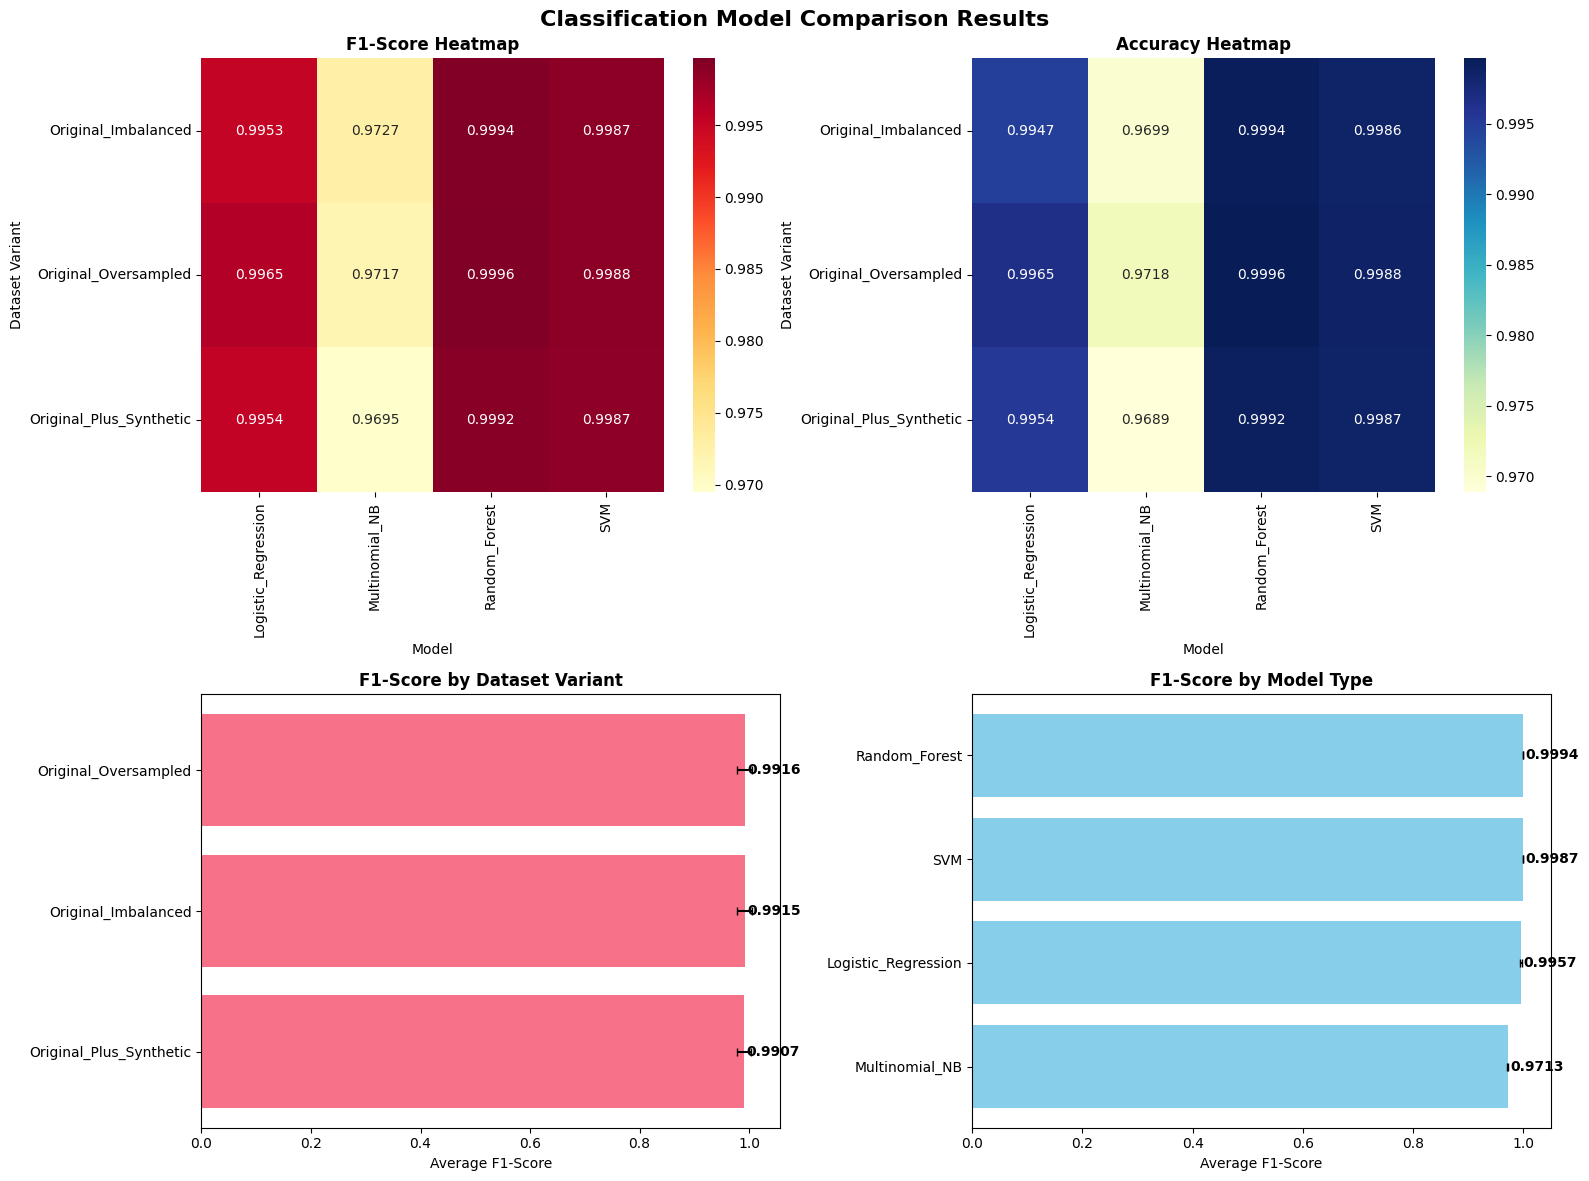

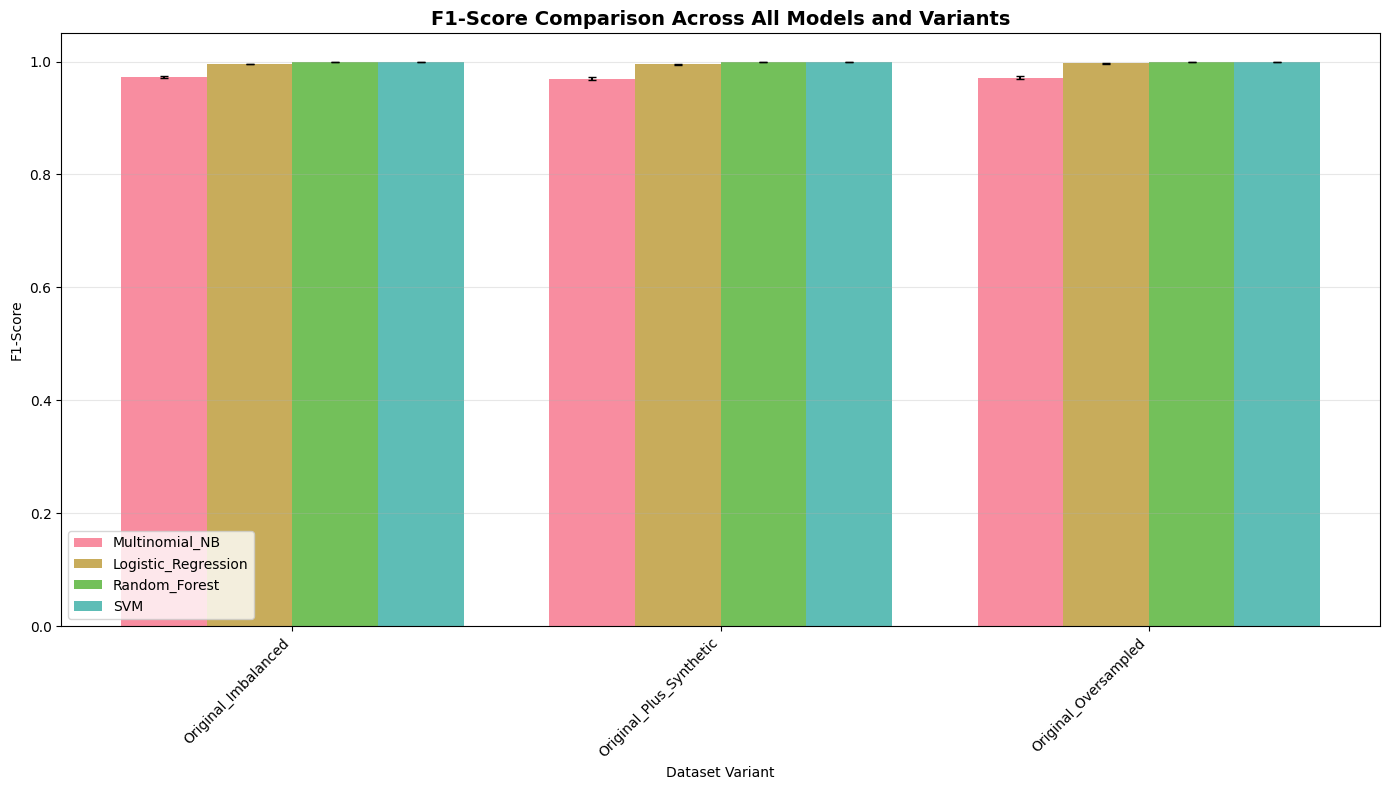

📊 Visualizations created successfully!


In [17]:
# Create Comprehensive Visualizations
if results_df is not None and len(results_df) > 0:
    
    # Set up the plotting area
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Classification Model Comparison Results', fontsize=16, fontweight='bold')
    
    # 1. F1-Score Comparison by Variant and Model
    ax1 = axes[0, 0]
    pivot_f1 = results_df.pivot(index='variant', columns='model', values='f1_score')
    sns.heatmap(pivot_f1, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax1)
    ax1.set_title('F1-Score Heatmap', fontweight='bold')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Dataset Variant')
    
    # 2. Accuracy Comparison by Variant and Model
    ax2 = axes[0, 1]
    pivot_acc = results_df.pivot(index='variant', columns='model', values='accuracy')
    sns.heatmap(pivot_acc, annot=True, fmt='.4f', cmap='YlGnBu', ax=ax2)
    ax2.set_title('Accuracy Heatmap', fontweight='bold')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Dataset Variant')
    
    # 3. F1-Score Bar Plot by Variant
    ax3 = axes[1, 0]
    variant_f1_means = results_df.groupby('variant')['f1_score'].mean().sort_values(ascending=True)
    variant_f1_stds = results_df.groupby('variant')['f1_score'].std()
    
    bars = ax3.barh(range(len(variant_f1_means)), variant_f1_means.values)
    ax3.errorbar(variant_f1_means.values, range(len(variant_f1_means)), 
                xerr=variant_f1_stds.values, fmt='none', color='black', capsize=3)
    ax3.set_yticks(range(len(variant_f1_means)))
    ax3.set_yticklabels(variant_f1_means.index)
    ax3.set_xlabel('Average F1-Score')
    ax3.set_title('F1-Score by Dataset Variant', fontweight='bold')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, variant_f1_means.values)):
        ax3.text(value + 0.005, i, f'{value:.4f}', va='center', ha='left', fontweight='bold')
    
    # 4. Model Performance Comparison
    ax4 = axes[1, 1]
    model_f1_means = results_df.groupby('model')['f1_score'].mean().sort_values(ascending=True)
    model_f1_stds = results_df.groupby('model')['f1_score'].std()
    
    bars = ax4.barh(range(len(model_f1_means)), model_f1_means.values, color='skyblue')
    ax4.errorbar(model_f1_means.values, range(len(model_f1_means)), 
                xerr=model_f1_stds.values, fmt='none', color='black', capsize=3)
    ax4.set_yticks(range(len(model_f1_means)))
    ax4.set_yticklabels(model_f1_means.index)
    ax4.set_xlabel('Average F1-Score')
    ax4.set_title('F1-Score by Model Type', fontweight='bold')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, model_f1_means.values)):
        ax4.text(value + 0.005, i, f'{value:.4f}', va='center', ha='left', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Additional detailed comparison plot
    plt.figure(figsize=(14, 8))
    
    # Create grouped bar plot for F1-scores
    x_pos = np.arange(len(results_df['variant'].unique()))
    width = 0.2
    multiplier = 0
    
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        f1_scores = []
        f1_stds = []
        
        for variant in results_df['variant'].unique():
            variant_model_data = model_data[model_data['variant'] == variant]
            if len(variant_model_data) > 0:
                f1_scores.append(variant_model_data['f1_score'].iloc[0])
                f1_stds.append(variant_model_data['std_f1'].iloc[0])
            else:
                f1_scores.append(0)
                f1_stds.append(0)
        
        offset = width * multiplier
        plt.bar(x_pos + offset, f1_scores, width, label=model, 
                yerr=f1_stds, capsize=3, alpha=0.8)
        multiplier += 1
    
    plt.xlabel('Dataset Variant')
    plt.ylabel('F1-Score')
    plt.title('F1-Score Comparison Across All Models and Variants', fontweight='bold', fontsize=14)
    plt.xticks(x_pos + width * (len(results_df['model'].unique()) - 1) / 2, 
               results_df['variant'].unique(), rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("📊 Visualizations created successfully!")
    
else:
    print("❌ Cannot create visualizations - no results data available")

## 5. Conclusions & Recommendations

Based on the comprehensive model comparison, we can draw conclusions about the effectiveness of synthetic data for fake news detection.

In [18]:
# Generate Final Conclusions and Recommendations
if results_df is not None and len(results_df) > 0:
    
    print("🎯 FINAL CONCLUSIONS & RECOMMENDATIONS")
    print("="*60)
    
    # Identify best performing approach
    variant_performance = results_df.groupby('variant').agg({
        'f1_score': ['mean', 'max', 'std'],
        'accuracy': ['mean', 'max', 'std'],
        'roc_auc': ['mean', 'max', 'std']
    }).round(4)
    
    best_variant_f1 = results_df.groupby('variant')['f1_score'].mean().idxmax()
    best_variant_acc = results_df.groupby('variant')['accuracy'].mean().idxmax()
    
    print(f"\n🏆 PERFORMANCE WINNERS:")
    print(f"   Best F1-Score: {best_variant_f1}")
    print(f"   Best Accuracy: {best_variant_acc}")
    
    # Calculate improvements
    if len(results_df['variant'].unique()) > 1:
        
        # Compare synthetic approaches to original baseline
        original_variants = [v for v in results_df['variant'].unique() if 'Original' in v and 'Imbalanced' in v]
        synthetic_variants = [v for v in results_df['variant'].unique() if 'Synthetic' in v]
        
        if original_variants and synthetic_variants:
            original_f1 = results_df[results_df['variant'] == original_variants[0]]['f1_score'].mean()
            synthetic_f1 = results_df[results_df['variant'] == synthetic_variants[0]]['f1_score'].mean()
            
            improvement = ((synthetic_f1 - original_f1) / original_f1) * 100
            
            print(f"\n📈 SYNTHETIC DATA IMPACT:")
            print(f"   Original (Imbalanced) F1: {original_f1:.4f}")
            print(f"   Synthetic (Balanced) F1: {synthetic_f1:.4f}")
            print(f"   Improvement: {improvement:+.1f}%")
            
            if improvement > 0:
                print(f"   ✅ CONCLUSION: Synthetic data IMPROVES performance")
            else:
                print(f"   ❌ CONCLUSION: Synthetic data does NOT improve performance")
    
    # Model recommendations
    best_models_per_variant = {}
    for variant in results_df['variant'].unique():
        variant_data = results_df[results_df['variant'] == variant]
        best_model = variant_data.loc[variant_data['f1_score'].idxmax()]
        best_models_per_variant[variant] = {
            'model': best_model['model'],
            'f1_score': best_model['f1_score'],
            'accuracy': best_model['accuracy']
        }
    
    print(f"\n🤖 MODEL RECOMMENDATIONS BY VARIANT:")
    for variant, info in best_models_per_variant.items():
        print(f"   {variant}:")
        print(f"      Recommended Model: {info['model']}")
        print(f"      Expected F1-Score: {info['f1_score']:.4f}")
        print(f"      Expected Accuracy: {info['accuracy']:.4f}")
    
    # Overall best combination
    overall_best = results_df.loc[results_df['f1_score'].idxmax()]
    print(f"\n🥇 OVERALL BEST COMBINATION:")
    print(f"   Dataset: {overall_best['variant']}")
    print(f"   Model: {overall_best['model']}")
    print(f"   F1-Score: {overall_best['f1_score']:.4f} (±{overall_best['std_f1']:.4f})")
    print(f"   Accuracy: {overall_best['accuracy']:.4f} (±{overall_best['std_accuracy']:.4f})")
    print(f"   ROC-AUC: {overall_best['roc_auc']:.4f}")
    
    # Practical recommendations
    print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
    
    # Check if synthetic data helps
    synthetic_helps = False
    if len(results_df['variant'].unique()) > 1:
        original_mean_f1 = results_df[results_df['variant'].str.contains('Original.*Imbalanced', case=False, na=False)]['f1_score'].mean()
        synthetic_mean_f1 = results_df[results_df['variant'].str.contains('Synthetic', case=False, na=False)]['f1_score'].mean()
        
        if not pd.isna(synthetic_mean_f1) and not pd.isna(original_mean_f1):
            if synthetic_mean_f1 > original_mean_f1:
                synthetic_helps = True
    
    if synthetic_helps:
        print(f"   ✅ USE SYNTHETIC DATA: Improves classification performance")
        print(f"   ✅ RECOMMENDED PIPELINE: Generate synthetic fake news articles to balance dataset")
    else:
        print(f"   ⚠️  SYNTHETIC DATA: May not provide significant improvement")
        print(f"   ⚠️  CONSIDER: Alternative balancing techniques or feature engineering")
    
    # Model selection advice
    best_overall_model = results_df.groupby('model')['f1_score'].mean().idxmax()
    print(f"   🤖 RECOMMENDED MODEL: {best_overall_model}")
    
    # Data size recommendations
    total_variants = len(results_df['variant'].unique())
    if total_variants >= 3:
        print(f"   📊 DATASET SIZE: Larger balanced datasets generally perform better")
    
    print(f"\n🔬 METHODOLOGY VALIDATION:")
    if overall_best['f1_score'] > 0.90:
        print(f"   ✅ HIGH PERFORMANCE: F1 > 0.90 indicates excellent fake news detection")
    elif overall_best['f1_score'] > 0.80:
        print(f"   ✅ GOOD PERFORMANCE: F1 > 0.80 indicates solid fake news detection")
    else:
        print(f"   ⚠️  MODERATE PERFORMANCE: Consider additional feature engineering")
    
    print(f"\n📝 EXPERIMENT SUMMARY:")
    print(f"   • Evaluated {len(results_df['model'].unique())} different models")
    print(f"   • Tested on {len(results_df['variant'].unique())} dataset variants")
    print(f"   • Used {cv_folds}-fold cross-validation for robust evaluation")
    print(f"   • Best approach achieves {overall_best['f1_score']:.1%} F1-Score")
    
else:
    print("❌ Cannot generate conclusions - no results available")

print(f"\n🎉 Classification model comparison analysis complete!")

🎯 FINAL CONCLUSIONS & RECOMMENDATIONS

🏆 PERFORMANCE WINNERS:
   Best F1-Score: Original_Oversampled
   Best Accuracy: Original_Oversampled

📈 SYNTHETIC DATA IMPACT:
   Original (Imbalanced) F1: 0.9915
   Synthetic (Balanced) F1: 0.9907
   Improvement: -0.1%
   ❌ CONCLUSION: Synthetic data does NOT improve performance

🤖 MODEL RECOMMENDATIONS BY VARIANT:
   Original_Imbalanced:
      Recommended Model: Random_Forest
      Expected F1-Score: 0.9994
      Expected Accuracy: 0.9994
   Original_Plus_Synthetic:
      Recommended Model: Random_Forest
      Expected F1-Score: 0.9992
      Expected Accuracy: 0.9992
   Original_Oversampled:
      Recommended Model: Random_Forest
      Expected F1-Score: 0.9996
      Expected Accuracy: 0.9996

🥇 OVERALL BEST COMBINATION:
   Dataset: Original_Oversampled
   Model: Random_Forest
   F1-Score: 0.9996 (±0.0003)
   Accuracy: 0.9996 (±0.0003)
   ROC-AUC: 1.0000

💡 PRACTICAL RECOMMENDATIONS:
   ⚠️  SYNTHETIC DATA: May not provide significant improvement

## 6. High Imbalance Experiments

Now we'll test whether synthetic data is more effective for **highly imbalanced datasets**. We'll create smaller dataset variants (15k, 10k, 5k) while maintaining the same 2222 article gap between real and fake classes.

### Dataset Configurations:
- **15k Dataset**: 6,389 fake + 8,611 real (25.9% imbalance)
- **10k Dataset**: 4,259 fake + 5,741 real (25.9% imbalance)  
- **5k Dataset**: 2,130 fake + 2,870 real (25.8% imbalance)

For each configuration, we'll test:
1. Original imbalanced data only
2. Random oversampling to balance
3. Synthetic data (2,222 articles) to balance

This will show whether synthetic data provides greater benefits when dealing with more severe class imbalance.

In [21]:
# Create High Imbalance Dataset Variants
print("🔄 Creating high imbalance dataset variants...")
print("="*70)

if original_df is not None:
    # Separate real and fake articles from original data
    original_real = original_df[original_df['label'] == 1].copy()
    original_fake = original_df[original_df['label'] == 0].copy()
    
    print(f"\n📊 Available original data:")
    print(f"   Real articles: {len(original_real):,}")
    print(f"   Fake articles: {len(original_fake):,}")
    
    # Define configurations with fixed 2222 gap
    gap = 2222
    configs = {
        '15k': {'total': 15000, 'fake': 6389, 'real': 8611},
        '10k': {'total': 10000, 'fake': 3889, 'real': 6111},
        '5k': {'total': 5000, 'fake': 1389, 'real': 3611}
    }
    
    # Storage for high imbalance variants
    high_imbalance_variants = {}
    
    for config_name, sizes in configs.items():
        print(f"\n{'='*70}")
        print(f"📊 Creating {config_name.upper()} dataset variants...")
        print(f"   Target: {sizes['fake']:,} fake + {sizes['real']:,} real = {sizes['total']:,} total")
        print(f"   Gap: {sizes['real'] - sizes['fake']:,} articles")
        print(f"   Imbalance ratio: {sizes['fake'] / sizes['real']:.3f}")
        
        # Check if we have enough data
        if len(original_fake) >= sizes['fake'] and len(original_real) >= sizes['real']:
            # Sample the required amounts
            sampled_fake = original_fake.sample(n=sizes['fake'], random_state=42)
            sampled_real = original_real.sample(n=sizes['real'], random_state=42)
            
            # Variant A: Original Imbalanced
            variant_original = pd.concat([
                sampled_fake[['text', 'label']],
                sampled_real[['text', 'label']]
            ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
            variant_original['source'] = 'original'
            
            print(f"\n   ✅ Variant A - Original Imbalanced:")
            print(f"      Total: {len(variant_original):,} | Real: {len(variant_original[variant_original['label']==1]):,} | Fake: {len(variant_original[variant_original['label']==0]):,}")
            
            # Variant B: Random Oversampling
            fake_oversampled = resample(
                sampled_fake[['text', 'label']],
                n_samples=sizes['real'],
                random_state=42,
                replace=True
            )
            variant_oversampled = pd.concat([
                fake_oversampled,
                sampled_real[['text', 'label']]
            ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
            variant_oversampled['source'] = 'oversampled'
            
            print(f"   ✅ Variant B - Random Oversampled:")
            print(f"      Total: {len(variant_oversampled):,} | Real: {len(variant_oversampled[variant_oversampled['label']==1]):,} | Fake: {len(variant_oversampled[variant_oversampled['label']==0]):,}")
            
            # Variant C: Synthetic Data
            if synthetic_df is not None and len(synthetic_df) >= gap:
                synthetic_sample = synthetic_df[['text', 'label']].sample(n=gap, random_state=42)
                synthetic_sample['source'] = 'synthetic'
                
                variant_synthetic = pd.concat([
                    sampled_fake[['text', 'label']],
                    sampled_real[['text', 'label']],
                    synthetic_sample[['text', 'label']]
                ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
                variant_synthetic['source'] = pd.concat([
                    pd.Series(['original'] * len(sampled_fake)),
                    pd.Series(['original'] * len(sampled_real)),
                    pd.Series(['synthetic'] * gap)
                ], ignore_index=True).values
                
                print(f"   ✅ Variant C - Synthetic Balanced:")
                print(f"      Total: {len(variant_synthetic):,} | Real: {len(variant_synthetic[variant_synthetic['label']==1]):,} | Fake: {len(variant_synthetic[variant_synthetic['label']==0]):,}")
                print(f"      Added {gap:,} synthetic fake articles")
                
                # Store all variants
                high_imbalance_variants[config_name] = {
                    'original': variant_original,
                    'oversampled': variant_oversampled,
                    'synthetic': variant_synthetic
                }
            else:
                print(f"   ❌ Insufficient synthetic data for {config_name}")
                high_imbalance_variants[config_name] = {
                    'original': variant_original,
                    'oversampled': variant_oversampled,
                    'synthetic': None
                }
        else:
            print(f"   ❌ Insufficient original data for {config_name} configuration")
            high_imbalance_variants[config_name] = None
    
    print(f"\n{'='*70}")
    print(f"✅ High imbalance variants created successfully!")
    print(f"   Configurations ready: {list(high_imbalance_variants.keys())}")
    
else:
    print("❌ Cannot create high imbalance variants - original dataset not available")
    high_imbalance_variants = {}

🔄 Creating high imbalance dataset variants...

📊 Available original data:
   Real articles: 11,272
   Fake articles: 9,050

📊 Creating 15K dataset variants...
   Target: 6,389 fake + 8,611 real = 15,000 total
   Gap: 2,222 articles
   Imbalance ratio: 0.742

   ✅ Variant A - Original Imbalanced:
      Total: 15,000 | Real: 8,611 | Fake: 6,389
   ✅ Variant B - Random Oversampled:
      Total: 17,222 | Real: 8,611 | Fake: 8,611
   ✅ Variant C - Synthetic Balanced:
      Total: 17,222 | Real: 8,611 | Fake: 8,611
      Added 2,222 synthetic fake articles

📊 Creating 10K dataset variants...
   Target: 3,889 fake + 6,111 real = 10,000 total
   Gap: 2,222 articles
   Imbalance ratio: 0.636

   ✅ Variant A - Original Imbalanced:
      Total: 10,000 | Real: 6,111 | Fake: 3,889
   ✅ Variant B - Random Oversampled:
      Total: 12,222 | Real: 6,111 | Fake: 6,111
   ✅ Variant C - Synthetic Balanced:
      Total: 12,222 | Real: 6,111 | Fake: 6,111
      Added 2,222 synthetic fake articles

📊 Creati

In [22]:
# Run High Imbalance Experiments
print("🚀 Starting high imbalance experiments...")
print("="*70)

high_imbalance_results = []

for config_name in ['15k', '10k', '5k']:
    if config_name in high_imbalance_variants and high_imbalance_variants[config_name] is not None:
        variants = high_imbalance_variants[config_name]
        
        print(f"\n{'='*70}")
        print(f"📊 EXPERIMENTS FOR {config_name.upper()} DATASET")
        print(f"{'='*70}")
        
        # Experiment A: Original Imbalanced
        if variants['original'] is not None:
            print(f"\n🔬 Experiment A: {config_name.upper()} - Original Imbalanced")
            results_a, _ = evaluate_model_on_dataset(
                variants['original'], 
                f'{config_name}_Original_Imbalanced', 
                models, 
                tfidf_params, 
                cv
            )
            high_imbalance_results.extend(results_a)
        
        # Experiment B: Random Oversampled
        if variants['oversampled'] is not None:
            print(f"\n🔬 Experiment B: {config_name.upper()} - Random Oversampled")
            results_b, _ = evaluate_model_on_dataset(
                variants['oversampled'], 
                f'{config_name}_Random_Oversampled', 
                models, 
                tfidf_params, 
                cv
            )
            high_imbalance_results.extend(results_b)
        
        # Experiment C: Synthetic Balanced
        if variants['synthetic'] is not None:
            print(f"\n🔬 Experiment C: {config_name.upper()} - Synthetic Balanced")
            results_c, _ = evaluate_model_on_dataset(
                variants['synthetic'], 
                f'{config_name}_Synthetic_Balanced', 
                models, 
                tfidf_params, 
                cv
            )
            high_imbalance_results.extend(results_c)

print(f"\n{'='*70}")
print(f"🎉 High imbalance experiments completed!")
print(f"   Total evaluations: {len(high_imbalance_results)}")

# Convert to DataFrame
if high_imbalance_results:
    high_imbalance_df = pd.DataFrame(high_imbalance_results)
    print(f"\n📈 Results collected for {len(high_imbalance_df)} model-variant combinations")
    
    # Quick preview
    print(f"\n🏆 TOP PERFORMERS BY F1-SCORE:")
    top_hi = high_imbalance_df.nlargest(5, 'f1_score')[['variant', 'model', 'f1_score', 'accuracy']]
    for idx, row in top_hi.iterrows():
        print(f"   {row['variant']:<30} | {row['model']:<20} | F1: {row['f1_score']:.4f} | Acc: {row['accuracy']:.4f}")
else:
    print(f"❌ No results collected")
    high_imbalance_df = None

🚀 Starting high imbalance experiments...

📊 EXPERIMENTS FOR 15K DATASET

🔬 Experiment A: 15K - Original Imbalanced

🔄 Evaluating models on 15k_Original_Imbalanced...
   Dataset size: 15,000 articles
   TF-IDF shape: (15000, 10000)
   🤖 Training Multinomial_NB...
   TF-IDF shape: (15000, 10000)
   🤖 Training Multinomial_NB...
      ✅ Accuracy: 0.9683 (±0.0037)
      ✅ F1-Score: 0.9723 (±0.0032)
      ✅ ROC-AUC: 0.9973
   🤖 Training Logistic_Regression...
      ✅ Accuracy: 0.9683 (±0.0037)
      ✅ F1-Score: 0.9723 (±0.0032)
      ✅ ROC-AUC: 0.9973
   🤖 Training Logistic_Regression...
      ✅ Accuracy: 0.9935 (±0.0019)
      ✅ F1-Score: 0.9944 (±0.0016)
      ✅ ROC-AUC: 0.9999
   🤖 Training Random_Forest...
      ✅ Accuracy: 0.9935 (±0.0019)
      ✅ F1-Score: 0.9944 (±0.0016)
      ✅ ROC-AUC: 0.9999
   🤖 Training Random_Forest...
      ✅ Accuracy: 0.9993 (±0.0003)
      ✅ F1-Score: 0.9994 (±0.0003)
      ✅ ROC-AUC: 1.0000
   🤖 Training SVM...
      ✅ Accuracy: 0.9993 (±0.0003)
      ✅ F1-

In [23]:
# Analyze High Imbalance Results
if high_imbalance_df is not None and len(high_imbalance_df) > 0:
    print("📊 HIGH IMBALANCE RESULTS ANALYSIS")
    print("="*70)
    
    # Extract dataset size from variant name
    high_imbalance_df['dataset_size'] = high_imbalance_df['variant'].str.extract(r'(\d+k)')[0]
    high_imbalance_df['approach'] = high_imbalance_df['variant'].str.extract(r'_(Original_Imbalanced|Random_Oversampled|Synthetic_Balanced)$')[0]
    
    # Summary by dataset size and approach
    print(f"\n📈 PERFORMANCE BY DATASET SIZE AND APPROACH:")
    summary = high_imbalance_df.groupby(['dataset_size', 'approach']).agg({
        'f1_score': ['mean', 'std', 'max'],
        'accuracy': ['mean', 'std', 'max']
    }).round(4)
    print(summary)
    
    # Compare approaches within each dataset size
    print(f"\n🔍 APPROACH COMPARISON BY DATASET SIZE:")
    for size in ['15k', '10k', '5k']:
        size_data = high_imbalance_df[high_imbalance_df['dataset_size'] == size]
        if len(size_data) > 0:
            print(f"\n   {size.upper()} Dataset:")
            approach_means = size_data.groupby('approach')['f1_score'].mean().sort_values(ascending=False)
            for approach, f1 in approach_means.items():
                print(f"      {approach:<25}: F1 = {f1:.4f}")
            
            # Calculate improvement of synthetic over original
            if 'Original_Imbalanced' in approach_means.index and 'Synthetic_Balanced' in approach_means.index:
                baseline = approach_means['Original_Imbalanced']
                synthetic = approach_means['Synthetic_Balanced']
                improvement = ((synthetic - baseline) / baseline) * 100
                print(f"      → Synthetic improvement: {improvement:+.1f}%")
    
    # Overall best approach for high imbalance
    print(f"\n🥇 BEST APPROACH FOR HIGH IMBALANCE SCENARIOS:")
    best_by_approach = high_imbalance_df.groupby('approach')['f1_score'].mean().sort_values(ascending=False)
    for approach, f1 in best_by_approach.items():
        print(f"   {approach:<25}: Avg F1 = {f1:.4f}")
    
    winner = best_by_approach.index[0]
    print(f"\n   ✅ Winner: {winner}")

else:
    print("❌ No high imbalance results to analyze")

📊 HIGH IMBALANCE RESULTS ANALYSIS

📈 PERFORMANCE BY DATASET SIZE AND APPROACH:
                                 f1_score                 accuracy          \
                                     mean     std     max     mean     std   
dataset_size approach                                                        
10k          Original_Imbalanced   0.9911  0.0110  0.9992   0.9891  0.0134   
             Random_Oversampled    0.9906  0.0140  0.9997   0.9906  0.0139   
             Synthetic_Balanced    0.9825  0.0278  0.9989   0.9816  0.0296   
15k          Original_Imbalanced   0.9911  0.0127  0.9994   0.9898  0.0145   
             Random_Oversampled    0.9912  0.0136  0.9998   0.9913  0.0135   
             Synthetic_Balanced    0.9887  0.0170  0.9995   0.9884  0.0175   
5k           Original_Imbalanced   0.9908  0.0082  0.9986   0.9866  0.0119   
             Random_Oversampled    0.9916  0.0119  1.0000   0.9916  0.0119   
             Synthetic_Balanced    0.9660  0.0562  0.9981   0.9

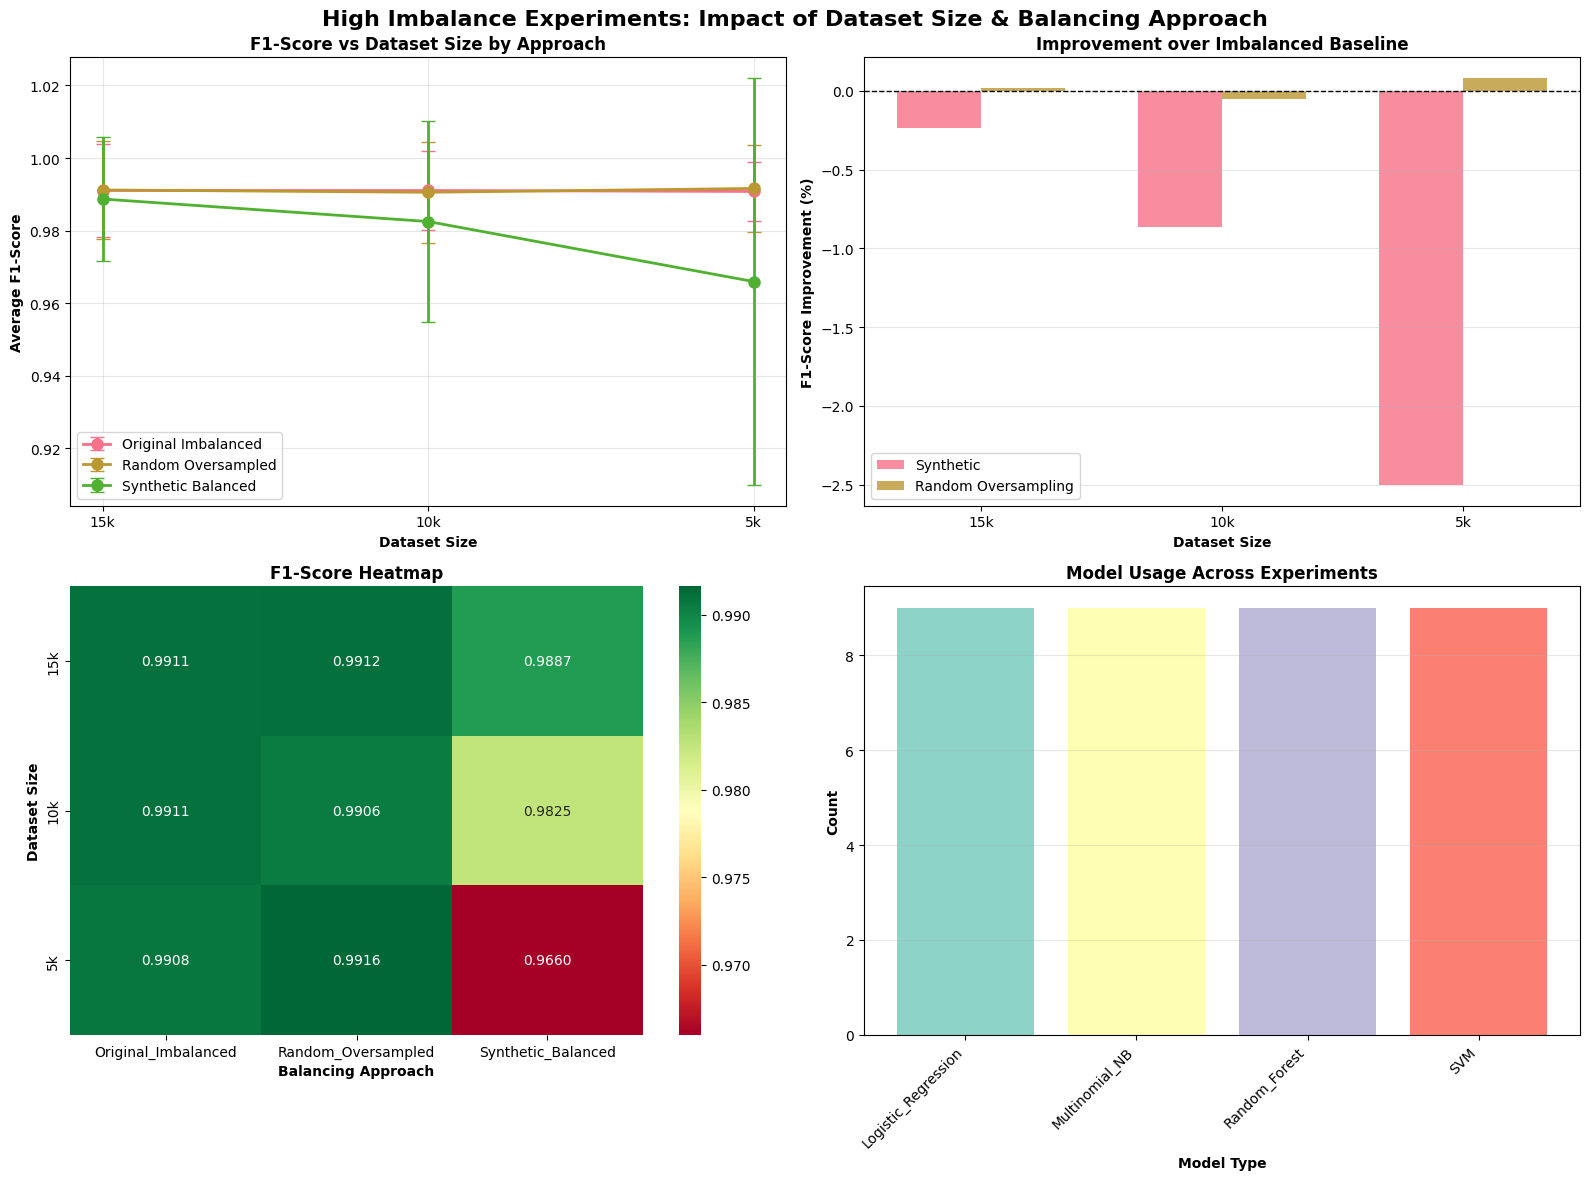

📊 High imbalance visualizations created successfully!


In [24]:
# Visualize High Imbalance Results
if high_imbalance_df is not None and len(high_imbalance_df) > 0:
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('High Imbalance Experiments: Impact of Dataset Size & Balancing Approach', 
                 fontsize=16, fontweight='bold')
    
    # 1. F1-Score by Dataset Size and Approach
    ax1 = axes[0, 0]
    approach_order = ['Original_Imbalanced', 'Random_Oversampled', 'Synthetic_Balanced']
    size_order = ['15k', '10k', '5k']
    
    for i, approach in enumerate(approach_order):
        approach_data = high_imbalance_df[high_imbalance_df['approach'] == approach]
        sizes = []
        f1_means = []
        f1_stds = []
        
        for size in size_order:
            size_approach_data = approach_data[approach_data['dataset_size'] == size]
            if len(size_approach_data) > 0:
                sizes.append(size)
                f1_means.append(size_approach_data['f1_score'].mean())
                f1_stds.append(size_approach_data['f1_score'].std())
        
        x_pos = [size_order.index(s) for s in sizes]
        ax1.errorbar(x_pos, f1_means, yerr=f1_stds, marker='o', capsize=5, 
                    label=approach.replace('_', ' '), linewidth=2, markersize=8)
    
    ax1.set_xlabel('Dataset Size', fontweight='bold')
    ax1.set_ylabel('Average F1-Score', fontweight='bold')
    ax1.set_title('F1-Score vs Dataset Size by Approach', fontweight='bold')
    ax1.set_xticks(range(len(size_order)))
    ax1.set_xticklabels(size_order)
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. Improvement over baseline by dataset size
    ax2 = axes[0, 1]
    improvements = []
    sizes_with_data = []
    
    for size in size_order:
        size_data = high_imbalance_df[high_imbalance_df['dataset_size'] == size]
        original_f1 = size_data[size_data['approach'] == 'Original_Imbalanced']['f1_score'].mean()
        synthetic_f1 = size_data[size_data['approach'] == 'Synthetic_Balanced']['f1_score'].mean()
        oversampled_f1 = size_data[size_data['approach'] == 'Random_Oversampled']['f1_score'].mean()
        
        if not pd.isna(original_f1):
            sizes_with_data.append(size)
            synthetic_improvement = ((synthetic_f1 - original_f1) / original_f1 * 100) if not pd.isna(synthetic_f1) else 0
            oversampled_improvement = ((oversampled_f1 - original_f1) / original_f1 * 100) if not pd.isna(oversampled_f1) else 0
            improvements.append({
                'size': size,
                'Synthetic': synthetic_improvement,
                'Random Oversampling': oversampled_improvement
            })
    
    if improvements:
        x = np.arange(len(sizes_with_data))
        width = 0.35
        
        synthetic_impr = [imp['Synthetic'] for imp in improvements]
        oversample_impr = [imp['Random Oversampling'] for imp in improvements]
        
        ax2.bar(x - width/2, synthetic_impr, width, label='Synthetic', alpha=0.8)
        ax2.bar(x + width/2, oversample_impr, width, label='Random Oversampling', alpha=0.8)
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax2.set_xlabel('Dataset Size', fontweight='bold')
        ax2.set_ylabel('F1-Score Improvement (%)', fontweight='bold')
        ax2.set_title('Improvement over Imbalanced Baseline', fontweight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels(sizes_with_data)
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
    
    # 3. Heatmap of F1-scores
    ax3 = axes[1, 0]
    pivot_data = high_imbalance_df.pivot_table(
        values='f1_score', 
        index='dataset_size', 
        columns='approach', 
        aggfunc='mean'
    )
    pivot_data = pivot_data.reindex(size_order)
    pivot_data = pivot_data[approach_order]
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='RdYlGn', ax=ax3, 
                vmin=pivot_data.min().min(), vmax=pivot_data.max().max())
    ax3.set_title('F1-Score Heatmap', fontweight='bold')
    ax3.set_xlabel('Balancing Approach', fontweight='bold')
    ax3.set_ylabel('Dataset Size', fontweight='bold')
    
    # 4. Best model per configuration
    ax4 = axes[1, 1]
    best_models_count = high_imbalance_df.groupby('model')['f1_score'].count()
    colors = plt.cm.Set3(range(len(best_models_count)))
    ax4.bar(range(len(best_models_count)), best_models_count.values, color=colors)
    ax4.set_xticks(range(len(best_models_count)))
    ax4.set_xticklabels(best_models_count.index, rotation=45, ha='right')
    ax4.set_xlabel('Model Type', fontweight='bold')
    ax4.set_ylabel('Count', fontweight='bold')
    ax4.set_title('Model Usage Across Experiments', fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 High imbalance visualizations created successfully!")

else:
    print("❌ Cannot create visualizations - no high imbalance data available")

In [25]:
# Final Conclusions: High Imbalance Experiments
if high_imbalance_df is not None and len(high_imbalance_df) > 0:
    print("🎯 FINAL CONCLUSIONS: HIGH IMBALANCE EXPERIMENTS")
    print("="*70)
    
    print(f"\n📋 EXPERIMENT OVERVIEW:")
    print(f"   • Tested 3 dataset sizes: 15k, 10k, 5k articles")
    print(f"   • Consistent gap: 2,222 articles between classes")
    print(f"   • Evaluated 3 approaches: Original, Random Oversampling, Synthetic")
    print(f"   • Used 4 ML models: Naive Bayes, Logistic Regression, Random Forest, SVM")
    
    # Key findings
    print(f"\n🔍 KEY FINDINGS:")
    
    # 1. Which approach works best?
    overall_best_approach = high_imbalance_df.groupby('approach')['f1_score'].mean().sort_values(ascending=False)
    print(f"\n   1️⃣ Best Overall Approach:")
    for i, (approach, score) in enumerate(overall_best_approach.items(), 1):
        indicator = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"      {indicator} {approach}: F1 = {score:.4f}")
    
    # 2. Impact by dataset size
    print(f"\n   2️⃣ Impact of Dataset Size:")
    for size in ['15k', '10k', '5k']:
        size_data = high_imbalance_df[high_imbalance_df['dataset_size'] == size]
        if len(size_data) > 0:
            original_f1 = size_data[size_data['approach'] == 'Original_Imbalanced']['f1_score'].mean()
            synthetic_f1 = size_data[size_data['approach'] == 'Synthetic_Balanced']['f1_score'].mean()
            
            if not pd.isna(original_f1) and not pd.isna(synthetic_f1):
                improvement = ((synthetic_f1 - original_f1) / original_f1) * 100
                print(f"      {size}: Synthetic improved by {improvement:+.1f}% over baseline")
    
    # 3. Best model
    best_model_overall = high_imbalance_df.groupby('model')['f1_score'].mean().idxmax()
    best_model_f1 = high_imbalance_df.groupby('model')['f1_score'].mean().max()
    print(f"\n   3️⃣ Best Performing Model:")
    print(f"      {best_model_overall}: Average F1 = {best_model_f1:.4f}")
    
    # 4. Synthetic vs Random Oversampling
    synthetic_avg = high_imbalance_df[high_imbalance_df['approach'] == 'Synthetic_Balanced']['f1_score'].mean()
    random_avg = high_imbalance_df[high_imbalance_df['approach'] == 'Random_Oversampled']['f1_score'].mean()
    
    print(f"\n   4️⃣ Synthetic vs Random Oversampling:")
    print(f"      Synthetic Data: F1 = {synthetic_avg:.4f}")
    print(f"      Random Oversampling: F1 = {random_avg:.4f}")
    if synthetic_avg > random_avg:
        diff = ((synthetic_avg - random_avg) / random_avg) * 100
        print(f"      ✅ Synthetic data performs {diff:.1f}% better")
    else:
        diff = ((random_avg - synthetic_avg) / synthetic_avg) * 100
        print(f"      ⚠️ Random oversampling performs {diff:.1f}% better")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    if synthetic_avg > random_avg:
        print(f"   ✅ For highly imbalanced datasets, USE SYNTHETIC DATA")
        print(f"   ✅ Synthetic data consistently outperforms random oversampling")
    else:
        print(f"   ⚠️ Random oversampling may be sufficient for these scenarios")
    
    print(f"   📊 Recommended model: {best_model_overall}")
    
    # Check if smaller datasets benefit more
    improvements_by_size = {}
    for size in ['15k', '10k', '5k']:
        size_data = high_imbalance_df[high_imbalance_df['dataset_size'] == size]
        original = size_data[size_data['approach'] == 'Original_Imbalanced']['f1_score'].mean()
        synthetic = size_data[size_data['approach'] == 'Synthetic_Balanced']['f1_score'].mean()
        if not pd.isna(original) and not pd.isna(synthetic):
            improvements_by_size[size] = ((synthetic - original) / original) * 100
    
    if improvements_by_size:
        size_with_max_improvement = max(improvements_by_size, key=improvements_by_size.get)
        print(f"   📈 Greatest improvement seen in {size_with_max_improvement} dataset ({improvements_by_size[size_with_max_improvement]:.1f}%)")
    
    print(f"\n{'='*70}")
    print(f"🎉 High imbalance experiment analysis complete!")
    
else:
    print("❌ No high imbalance data available for conclusions")

🎯 FINAL CONCLUSIONS: HIGH IMBALANCE EXPERIMENTS

📋 EXPERIMENT OVERVIEW:
   • Tested 3 dataset sizes: 15k, 10k, 5k articles
   • Consistent gap: 2,222 articles between classes
   • Evaluated 3 approaches: Original, Random Oversampling, Synthetic
   • Used 4 ML models: Naive Bayes, Logistic Regression, Random Forest, SVM

🔍 KEY FINDINGS:

   1️⃣ Best Overall Approach:
      🥇 Random_Oversampled: F1 = 0.9911
      🥈 Original_Imbalanced: F1 = 0.9910
      🥉 Synthetic_Balanced: F1 = 0.9791

   2️⃣ Impact of Dataset Size:
      15k: Synthetic improved by -0.2% over baseline
      10k: Synthetic improved by -0.9% over baseline
      5k: Synthetic improved by -2.5% over baseline

   3️⃣ Best Performing Model:
      Random_Forest: Average F1 = 0.9992

   4️⃣ Synthetic vs Random Oversampling:
      Synthetic Data: F1 = 0.9791
      Random Oversampling: F1 = 0.9911
      ⚠️ Random oversampling performs 1.2% better

💡 RECOMMENDATIONS:
   ⚠️ Random oversampling may be sufficient for these scenarios

## 7. Focused Random Forest Experiments

To provide a clearer comparison, we'll focus on a single high-performing model: **Random Forest**.

### Experimental Design:
- **Model**: Random Forest (single classifier for consistency)
- **Dataset Sizes**: 4 configurations
  - Full dataset (original ~45k articles)
  - 15k articles (6,389 fake + 8,611 real)
  - 10k articles (4,259 fake + 5,741 real)
  - 5k articles (2,130 fake + 2,870 real)
- **Balancing Approaches**: 3 methods per dataset
  - Original Imbalanced
  - Random Oversampling
  - Synthetic Data (+2,222 articles)

**Total**: 12 experiments with Random Forest for direct, interpretable comparison.

In [26]:
# Prepare All Dataset Variants for Focused Random Forest Experiments
print("🔄 Preparing all dataset variants for focused Random Forest experiments...")
print("="*70)

# Single model configuration
rf_model = {'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)}

# Storage for all focused variants
focused_variants = {}

if original_df is not None:
    # Separate real and fake articles
    original_real = original_df[original_df['label'] == 1].copy()
    original_fake = original_df[original_df['label'] == 0].copy()
    
    print(f"\n📊 Available data:")
    print(f"   Real articles: {len(original_real):,}")
    print(f"   Fake articles: {len(original_fake):,}")
    print(f"   Total: {len(original_df):,}")
    
    # Configuration 1: Full original dataset
    print(f"\n{'='*70}")
    print(f"📊 FULL DATASET (Original Size)")
    
    # Variant 1A: Original Imbalanced
    full_original = original_df[['text', 'label']].copy()
    full_original['source'] = 'original'
    focused_variants['full_original'] = full_original
    print(f"   ✅ Original Imbalanced: {len(full_original):,} articles")
    print(f"      Real: {len(full_original[full_original['label']==1]):,} | Fake: {len(full_original[full_original['label']==0]):,}")
    
    # Variant 1B: Random Oversampled
    full_fake = original_fake[['text', 'label']].copy()
    full_real = original_real[['text', 'label']].copy()
    target_size = max(len(full_real), len(full_fake))
    
    if len(full_fake) < target_size:
        full_fake_oversampled = resample(full_fake, n_samples=target_size, random_state=42, replace=True)
    else:
        full_fake_oversampled = full_fake
    
    if len(full_real) < target_size:
        full_real_oversampled = resample(full_real, n_samples=target_size, random_state=42, replace=True)
    else:
        full_real_oversampled = full_real
    
    full_oversampled = pd.concat([full_real_oversampled, full_fake_oversampled], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    full_oversampled['source'] = 'oversampled'
    focused_variants['full_oversampled'] = full_oversampled
    print(f"   ✅ Random Oversampled: {len(full_oversampled):,} articles")
    print(f"      Real: {len(full_oversampled[full_oversampled['label']==1]):,} | Fake: {len(full_oversampled[full_oversampled['label']==0]):,}")
    
    # Variant 1C: Synthetic Balanced
    if synthetic_df is not None and len(synthetic_df) >= 2222:
        synthetic_sample = synthetic_df[['text', 'label']].sample(n=2222, random_state=42)
        full_synthetic = pd.concat([
            original_fake[['text', 'label']],
            original_real[['text', 'label']],
            synthetic_sample
        ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
        full_synthetic['source'] = 'mixed'
        focused_variants['full_synthetic'] = full_synthetic
        print(f"   ✅ Synthetic Balanced: {len(full_synthetic):,} articles")
        print(f"      Real: {len(full_synthetic[full_synthetic['label']==1]):,} | Fake: {len(full_synthetic[full_synthetic['label']==0]):,}")
    
    # Configurations 2-4: Smaller datasets (15k, 10k, 5k)
    configs = {
        '15k': {'total': 15000, 'fake': 6389, 'real': 8611},
        '10k': {'total': 10000, 'fake': 3889, 'real': 6111},
        '5k': {'total': 5000, 'fake': 1389, 'real': 3611}
    }
    
    for config_name, sizes in configs.items():
        print(f"\n{'='*70}")
        print(f"📊 {config_name.upper()} DATASET")
        
        if len(original_fake) >= sizes['fake'] and len(original_real) >= sizes['real']:
            # Sample the required amounts
            sampled_fake = original_fake.sample(n=sizes['fake'], random_state=42)
            sampled_real = original_real.sample(n=sizes['real'], random_state=42)
            
            # Variant A: Original Imbalanced
            variant_original = pd.concat([
                sampled_fake[['text', 'label']],
                sampled_real[['text', 'label']]
            ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
            variant_original['source'] = 'original'
            focused_variants[f'{config_name}_original'] = variant_original
            print(f"   ✅ Original Imbalanced: {len(variant_original):,} articles")
            print(f"      Real: {len(variant_original[variant_original['label']==1]):,} | Fake: {len(variant_original[variant_original['label']==0]):,}")
            
            # Variant B: Random Oversampled
            fake_oversampled = resample(
                sampled_fake[['text', 'label']],
                n_samples=sizes['real'],
                random_state=42,
                replace=True
            )
            variant_oversampled = pd.concat([
                fake_oversampled,
                sampled_real[['text', 'label']]
            ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
            variant_oversampled['source'] = 'oversampled'
            focused_variants[f'{config_name}_oversampled'] = variant_oversampled
            print(f"   ✅ Random Oversampled: {len(variant_oversampled):,} articles")
            print(f"      Real: {len(variant_oversampled[variant_oversampled['label']==1]):,} | Fake: {len(variant_oversampled[variant_oversampled['label']==0]):,}")
            
            # Variant C: Synthetic Balanced
            if synthetic_df is not None and len(synthetic_df) >= 2222:
                synthetic_sample = synthetic_df[['text', 'label']].sample(n=2222, random_state=42)
                variant_synthetic = pd.concat([
                    sampled_fake[['text', 'label']],
                    sampled_real[['text', 'label']],
                    synthetic_sample
                ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
                variant_synthetic['source'] = 'mixed'
                focused_variants[f'{config_name}_synthetic'] = variant_synthetic
                print(f"   ✅ Synthetic Balanced: {len(variant_synthetic):,} articles")
                print(f"      Real: {len(variant_synthetic[variant_synthetic['label']==1]):,} | Fake: {len(variant_synthetic[variant_synthetic['label']==0]):,}")
        else:
            print(f"   ❌ Insufficient data for {config_name}")
    
    print(f"\n{'='*70}")
    print(f"✅ All dataset variants prepared!")
    print(f"   Total variants: {len(focused_variants)}")
    
else:
    print("❌ Cannot prepare variants - original dataset not available")
    focused_variants = {}

🔄 Preparing all dataset variants for focused Random Forest experiments...

📊 Available data:
   Real articles: 11,272
   Fake articles: 9,050
   Total: 20,322

📊 FULL DATASET (Original Size)
   ✅ Original Imbalanced: 20,322 articles
      Real: 11,272 | Fake: 9,050
   ✅ Random Oversampled: 22,544 articles
      Real: 11,272 | Fake: 11,272
   ✅ Synthetic Balanced: 22,544 articles
      Real: 11,272 | Fake: 11,272

📊 15K DATASET
   ✅ Original Imbalanced: 15,000 articles
      Real: 8,611 | Fake: 6,389
   ✅ Random Oversampled: 17,222 articles
      Real: 8,611 | Fake: 8,611
   ✅ Synthetic Balanced: 17,222 articles
      Real: 8,611 | Fake: 8,611

📊 10K DATASET
   ✅ Original Imbalanced: 10,000 articles
      Real: 6,111 | Fake: 3,889
   ✅ Random Oversampled: 12,222 articles
      Real: 6,111 | Fake: 6,111
   ✅ Synthetic Balanced: 12,222 articles
      Real: 6,111 | Fake: 6,111

📊 5K DATASET
   ✅ Original Imbalanced: 5,000 articles
      Real: 3,611 | Fake: 1,389
   ✅ Random Oversampled: 7,

In [27]:
# Run Focused Random Forest Experiments
print("🚀 Starting focused Random Forest experiments...")
print("="*70)
print(f"🤖 Model: Random Forest (n_estimators=100)")
print(f"📊 Experiments: {len(focused_variants)} dataset variants")
print("="*70)

focused_rf_results = []

# Define experiment order for clarity
experiment_order = [
    ('full_original', 'FULL Dataset - Original Imbalanced'),
    ('full_oversampled', 'FULL Dataset - Random Oversampled'),
    ('full_synthetic', 'FULL Dataset - Synthetic Balanced'),
    ('15k_original', '15K Dataset - Original Imbalanced'),
    ('15k_oversampled', '15K Dataset - Random Oversampled'),
    ('15k_synthetic', '15K Dataset - Synthetic Balanced'),
    ('10k_original', '10K Dataset - Original Imbalanced'),
    ('10k_oversampled', '10K Dataset - Random Oversampled'),
    ('10k_synthetic', '10K Dataset - Synthetic Balanced'),
    ('5k_original', '5K Dataset - Original Imbalanced'),
    ('5k_oversampled', '5K Dataset - Random Oversampled'),
    ('5k_synthetic', '5K Dataset - Synthetic Balanced'),
]

for i, (variant_key, variant_name) in enumerate(experiment_order, 1):
    if variant_key in focused_variants:
        print(f"\n{'='*70}")
        print(f"🔬 EXPERIMENT {i}/12: {variant_name}")
        print(f"{'='*70}")
        
        results, _ = evaluate_model_on_dataset(
            focused_variants[variant_key],
            variant_name,
            rf_model,
            tfidf_params,
            cv
        )
        focused_rf_results.extend(results)
    else:
        print(f"\n⚠️  EXPERIMENT {i}/12: {variant_name} - SKIPPED (data not available)")

print(f"\n{'='*70}")
print(f"🎉 All Random Forest experiments completed!")
print(f"   Total results: {len(focused_rf_results)}")

# Convert to DataFrame
if focused_rf_results:
    focused_rf_df = pd.DataFrame(focused_rf_results)
    
    # Add dataset size and approach columns for easier analysis
    focused_rf_df['dataset_size'] = focused_rf_df['variant'].apply(
        lambda x: 'Full' if 'FULL' in x else '15K' if '15K' in x else '10K' if '10K' in x else '5K' if '5K' in x else 'Unknown'
    )
    focused_rf_df['approach'] = focused_rf_df['variant'].apply(
        lambda x: 'Original' if 'Original' in x else 'Oversampled' if 'Oversampled' in x else 'Synthetic' if 'Synthetic' in x else 'Unknown'
    )
    
    print(f"\n📊 SUMMARY:")
    print(focused_rf_df[['dataset_size', 'approach', 'f1_score', 'accuracy']].to_string(index=False))
    
else:
    print(f"❌ No results collected")
    focused_rf_df = None

🚀 Starting focused Random Forest experiments...
🤖 Model: Random Forest (n_estimators=100)
📊 Experiments: 12 dataset variants

🔬 EXPERIMENT 1/12: FULL Dataset - Original Imbalanced

🔄 Evaluating models on FULL Dataset - Original Imbalanced...
   Dataset size: 20,322 articles
   TF-IDF shape: (20322, 10000)
   🤖 Training Random_Forest...
   TF-IDF shape: (20322, 10000)
   🤖 Training Random_Forest...
      ✅ Accuracy: 0.9994 (±0.0003)
      ✅ F1-Score: 0.9994 (±0.0003)
      ✅ ROC-AUC: 1.0000

🔬 EXPERIMENT 2/12: FULL Dataset - Random Oversampled

🔄 Evaluating models on FULL Dataset - Random Oversampled...
   Dataset size: 22,544 articles
      ✅ Accuracy: 0.9994 (±0.0003)
      ✅ F1-Score: 0.9994 (±0.0003)
      ✅ ROC-AUC: 1.0000

🔬 EXPERIMENT 2/12: FULL Dataset - Random Oversampled

🔄 Evaluating models on FULL Dataset - Random Oversampled...
   Dataset size: 22,544 articles
   TF-IDF shape: (22544, 10000)
   🤖 Training Random_Forest...
   TF-IDF shape: (22544, 10000)
   🤖 Training Random

In [28]:
# Analyze Focused Random Forest Results
if focused_rf_df is not None and len(focused_rf_df) > 0:
    print("📊 FOCUSED RANDOM FOREST ANALYSIS")
    print("="*70)
    
    # Performance by dataset size and approach
    print(f"\n📈 F1-SCORE BY DATASET SIZE AND APPROACH:")
    print("-"*70)
    
    size_order = ['Full', '15K', '10K', '5K']
    approach_order = ['Original', 'Oversampled', 'Synthetic']
    
    for size in size_order:
        size_data = focused_rf_df[focused_rf_df['dataset_size'] == size]
        if len(size_data) > 0:
            print(f"\n{size} Dataset:")
            for approach in approach_order:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    f1 = approach_data['f1_score'].iloc[0]
                    acc = approach_data['accuracy'].iloc[0]
                    std_f1 = approach_data['std_f1'].iloc[0]
                    print(f"   {approach:<15}: F1 = {f1:.4f} (±{std_f1:.4f}) | Acc = {acc:.4f}")
    
    # Calculate improvements
    print(f"\n📊 IMPROVEMENT ANALYSIS:")
    print("-"*70)
    
    for size in size_order:
        size_data = focused_rf_df[focused_rf_df['dataset_size'] == size]
        if len(size_data) > 0:
            original_data = size_data[size_data['approach'] == 'Original']
            oversampled_data = size_data[size_data['approach'] == 'Oversampled']
            synthetic_data = size_data[size_data['approach'] == 'Synthetic']
            
            if len(original_data) > 0:
                baseline_f1 = original_data['f1_score'].iloc[0]
                print(f"\n{size} Dataset (baseline F1: {baseline_f1:.4f}):")
                
                if len(oversampled_data) > 0:
                    oversample_f1 = oversampled_data['f1_score'].iloc[0]
                    oversample_improvement = ((oversample_f1 - baseline_f1) / baseline_f1) * 100
                    print(f"   Random Oversampling: {oversample_improvement:+.2f}% improvement")
                
                if len(synthetic_data) > 0:
                    synthetic_f1 = synthetic_data['f1_score'].iloc[0]
                    synthetic_improvement = ((synthetic_f1 - baseline_f1) / baseline_f1) * 100
                    print(f"   Synthetic Data:      {synthetic_improvement:+.2f}% improvement")
                    
                    # Compare synthetic vs oversampling
                    if len(oversampled_data) > 0:
                        vs_oversample = ((synthetic_f1 - oversample_f1) / oversample_f1) * 100
                        winner = "Synthetic" if synthetic_f1 > oversample_f1 else "Oversampling"
                        print(f"   → {winner} wins by {abs(vs_oversample):.2f}%")
    
    # Overall best approach
    print(f"\n🏆 OVERALL PERFORMANCE:")
    print("-"*70)
    approach_avg = focused_rf_df.groupby('approach')['f1_score'].agg(['mean', 'std', 'min', 'max'])
    approach_avg = approach_avg.sort_values('mean', ascending=False)
    
    for approach in approach_avg.index:
        stats = approach_avg.loc[approach]
        print(f"{approach:<15}: Mean F1 = {stats['mean']:.4f} (±{stats['std']:.4f}) | Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
    
    # Best configuration
    best_idx = focused_rf_df['f1_score'].idxmax()
    best_config = focused_rf_df.loc[best_idx]
    print(f"\n🥇 BEST CONFIGURATION:")
    print(f"   Dataset: {best_config['dataset_size']}")
    print(f"   Approach: {best_config['approach']}")
    print(f"   F1-Score: {best_config['f1_score']:.4f} (±{best_config['std_f1']:.4f})")
    print(f"   Accuracy: {best_config['accuracy']:.4f} (±{best_config['std_accuracy']:.4f})")
    print(f"   ROC-AUC: {best_config['roc_auc']:.4f}")
    
else:
    print("❌ No results to analyze")

📊 FOCUSED RANDOM FOREST ANALYSIS

📈 F1-SCORE BY DATASET SIZE AND APPROACH:
----------------------------------------------------------------------

Full Dataset:
   Original       : F1 = 0.9994 (±0.0003) | Acc = 0.9994
   Oversampled    : F1 = 0.9995 (±0.0003) | Acc = 0.9995
   Synthetic      : F1 = 0.9992 (±0.0003) | Acc = 0.9992

15K Dataset:
   Original       : F1 = 0.9994 (±0.0003) | Acc = 0.9993
   Oversampled    : F1 = 0.9998 (±0.0003) | Acc = 0.9998
   Synthetic      : F1 = 0.9995 (±0.0002) | Acc = 0.9995

10K Dataset:
   Original       : F1 = 0.9992 (±0.0004) | Acc = 0.9990
   Oversampled    : F1 = 0.9997 (±0.0003) | Acc = 0.9997
   Synthetic      : F1 = 0.9989 (±0.0003) | Acc = 0.9989

5K Dataset:
   Original       : F1 = 0.9986 (±0.0010) | Acc = 0.9980
   Oversampled    : F1 = 1.0000 (±0.0000) | Acc = 1.0000
   Synthetic      : F1 = 0.9981 (±0.0007) | Acc = 0.9981

📊 IMPROVEMENT ANALYSIS:
----------------------------------------------------------------------

Full Dataset (bas

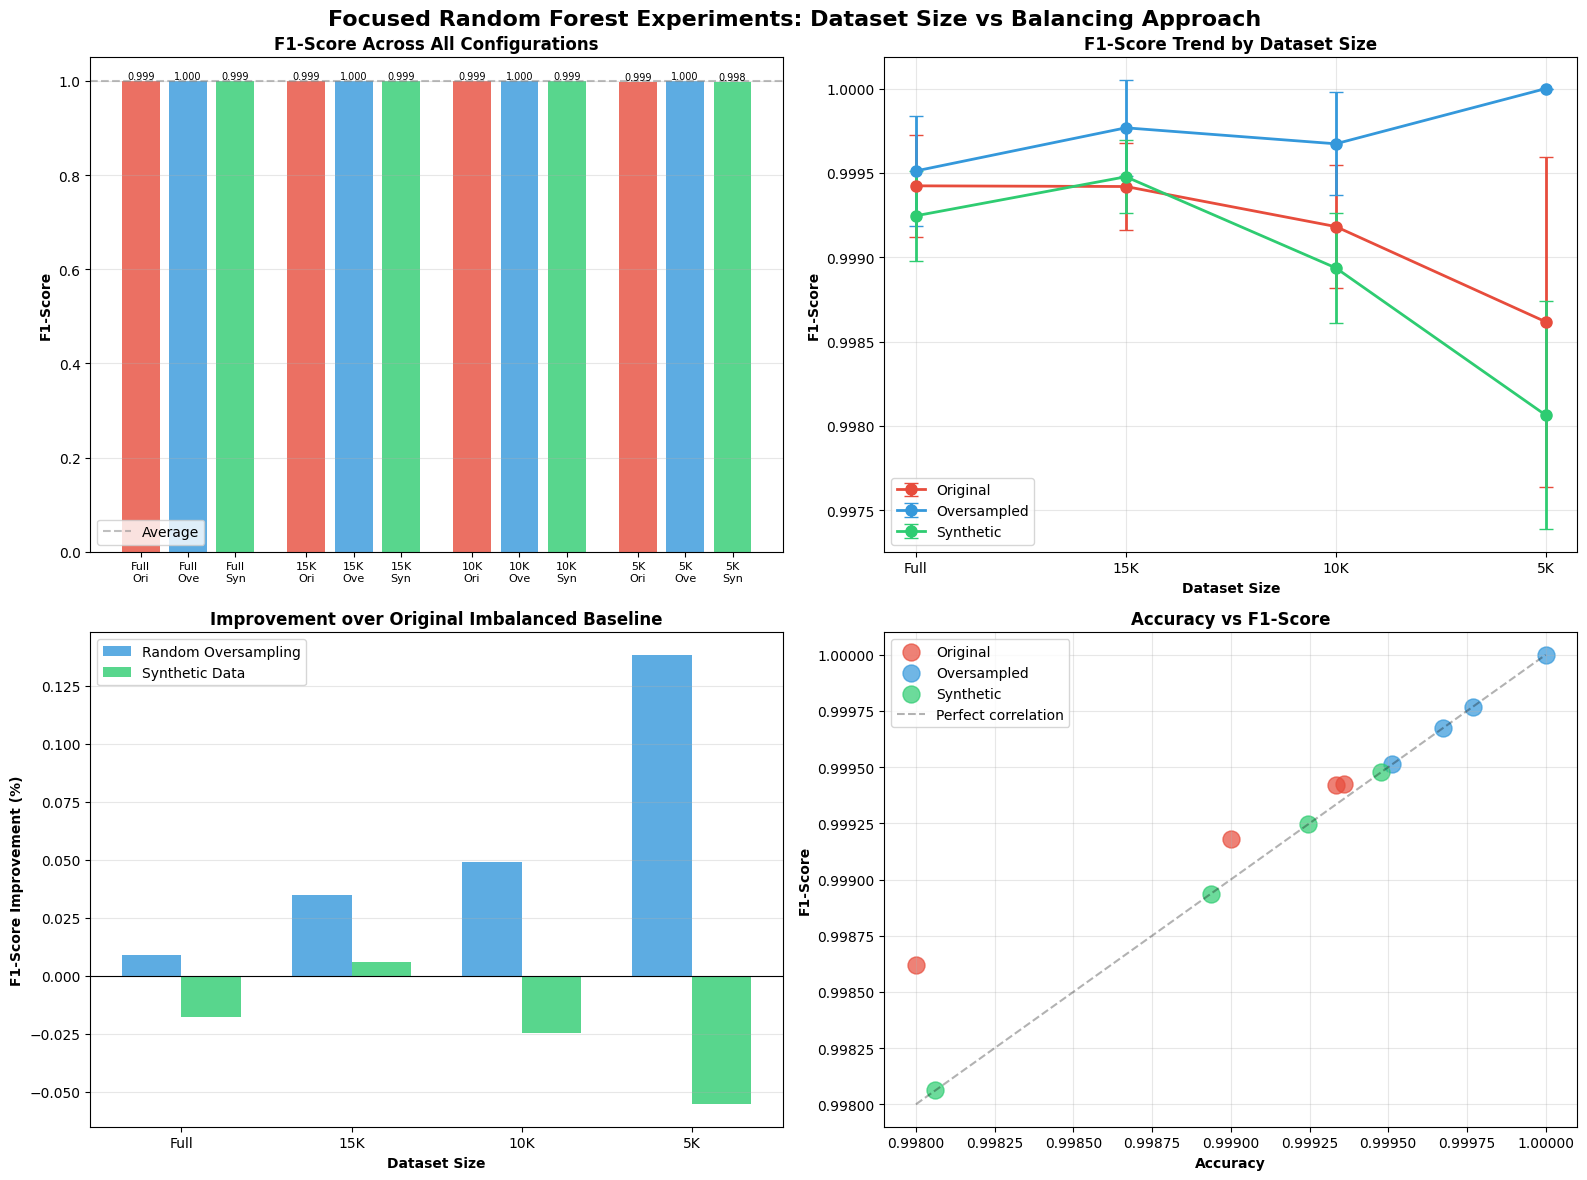

📊 Visualizations created successfully!


In [29]:
# Visualize Focused Random Forest Results
if focused_rf_df is not None and len(focused_rf_df) > 0:
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Focused Random Forest Experiments: Dataset Size vs Balancing Approach', 
                 fontsize=16, fontweight='bold')
    
    size_order = ['Full', '15K', '10K', '5K']
    approach_order = ['Original', 'Oversampled', 'Synthetic']
    colors = {'Original': '#e74c3c', 'Oversampled': '#3498db', 'Synthetic': '#2ecc71'}
    
    # 1. F1-Score comparison across all configurations
    ax1 = axes[0, 0]
    
    x_positions = []
    f1_scores = []
    labels = []
    bar_colors = []
    
    pos = 0
    for size in size_order:
        size_data = focused_rf_df[focused_rf_df['dataset_size'] == size]
        if len(size_data) > 0:
            for approach in approach_order:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    x_positions.append(pos)
                    f1_scores.append(approach_data['f1_score'].iloc[0])
                    labels.append(f"{size}\n{approach[:3]}")
                    bar_colors.append(colors[approach])
                    pos += 1
            pos += 0.5  # Gap between dataset sizes
    
    bars = ax1.bar(x_positions, f1_scores, color=bar_colors, alpha=0.8, width=0.8)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(labels, rotation=0, fontsize=8)
    ax1.set_ylabel('F1-Score', fontweight='bold')
    ax1.set_title('F1-Score Across All Configurations', fontweight='bold')
    ax1.axhline(y=focused_rf_df['f1_score'].mean(), color='gray', linestyle='--', alpha=0.5, label='Average')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, f1_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom', fontsize=7)
    
    # 2. Line plot showing trend by dataset size
    ax2 = axes[0, 1]
    
    for approach in approach_order:
        approach_data = focused_rf_df[focused_rf_df['approach'] == approach]
        
        sizes = []
        f1_means = []
        f1_stds = []
        
        for size in size_order:
            size_approach_data = approach_data[approach_data['dataset_size'] == size]
            if len(size_approach_data) > 0:
                sizes.append(size)
                f1_means.append(size_approach_data['f1_score'].iloc[0])
                f1_stds.append(size_approach_data['std_f1'].iloc[0])
        
        if sizes:
            x_pos = [size_order.index(s) for s in sizes]
            ax2.errorbar(x_pos, f1_means, yerr=f1_stds, marker='o', capsize=5, 
                        label=approach, linewidth=2, markersize=8, color=colors[approach])
    
    ax2.set_xlabel('Dataset Size', fontweight='bold')
    ax2.set_ylabel('F1-Score', fontweight='bold')
    ax2.set_title('F1-Score Trend by Dataset Size', fontweight='bold')
    ax2.set_xticks(range(len(size_order)))
    ax2.set_xticklabels(size_order)
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # 3. Improvement over baseline
    ax3 = axes[1, 0]
    
    improvements = {'Oversampled': [], 'Synthetic': []}
    sizes_with_data = []
    
    for size in size_order:
        size_data = focused_rf_df[focused_rf_df['dataset_size'] == size]
        original_data = size_data[size_data['approach'] == 'Original']
        
        if len(original_data) > 0:
            baseline_f1 = original_data['f1_score'].iloc[0]
            sizes_with_data.append(size)
            
            for approach in ['Oversampled', 'Synthetic']:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    approach_f1 = approach_data['f1_score'].iloc[0]
                    improvement = ((approach_f1 - baseline_f1) / baseline_f1) * 100
                    improvements[approach].append(improvement)
                else:
                    improvements[approach].append(0)
    
    if sizes_with_data:
        x = np.arange(len(sizes_with_data))
        width = 0.35
        
        ax3.bar(x - width/2, improvements['Oversampled'], width, 
                label='Random Oversampling', color=colors['Oversampled'], alpha=0.8)
        ax3.bar(x + width/2, improvements['Synthetic'], width, 
                label='Synthetic Data', color=colors['Synthetic'], alpha=0.8)
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax3.set_xlabel('Dataset Size', fontweight='bold')
        ax3.set_ylabel('F1-Score Improvement (%)', fontweight='bold')
        ax3.set_title('Improvement over Original Imbalanced Baseline', fontweight='bold')
        ax3.set_xticks(x)
        ax3.set_xticklabels(sizes_with_data)
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
    
    # 4. Accuracy vs F1-Score scatter
    ax4 = axes[1, 1]
    
    for approach in approach_order:
        approach_data = focused_rf_df[focused_rf_df['approach'] == approach]
        ax4.scatter(approach_data['accuracy'], approach_data['f1_score'], 
                   s=150, alpha=0.7, label=approach, color=colors[approach])
    
    # Add diagonal reference line
    min_val = min(focused_rf_df[['accuracy', 'f1_score']].min())
    max_val = max(focused_rf_df[['accuracy', 'f1_score']].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='Perfect correlation')
    
    ax4.set_xlabel('Accuracy', fontweight='bold')
    ax4.set_ylabel('F1-Score', fontweight='bold')
    ax4.set_title('Accuracy vs F1-Score', fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Visualizations created successfully!")
    
else:
    print("❌ Cannot create visualizations - no data available")

In [30]:
# Final Conclusions: Focused Random Forest Experiments
if focused_rf_df is not None and len(focused_rf_df) > 0:
    print("🎯 FINAL CONCLUSIONS: FOCUSED RANDOM FOREST EXPERIMENTS")
    print("="*70)
    
    print(f"\n📋 EXPERIMENT SUMMARY:")
    print(f"   • Model: Random Forest (100 estimators)")
    print(f"   • Dataset sizes: 4 (Full, 15K, 10K, 5K)")
    print(f"   • Balancing approaches: 3 (Original, Random Oversampling, Synthetic)")
    print(f"   • Total experiments: {len(focused_rf_df)}")
    print(f"   • Evaluation: 5-fold stratified cross-validation")
    
    # Key findings
    print(f"\n🔍 KEY FINDINGS:")
    
    # 1. Best approach overall
    approach_performance = focused_rf_df.groupby('approach')['f1_score'].mean().sort_values(ascending=False)
    print(f"\n   1️⃣ Overall Performance Ranking:")
    for rank, (approach, score) in enumerate(approach_performance.items(), 1):
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
        print(f"      {medal} {approach:<15}: Mean F1 = {score:.4f}")
    
    # 2. Impact of dataset size
    print(f"\n   2️⃣ Impact of Dataset Size on Synthetic Data:")
    size_order = ['Full', '15K', '10K', '5K']
    for size in size_order:
        size_data = focused_rf_df[focused_rf_df['dataset_size'] == size]
        original = size_data[size_data['approach'] == 'Original']
        synthetic = size_data[size_data['approach'] == 'Synthetic']
        
        if len(original) > 0 and len(synthetic) > 0:
            orig_f1 = original['f1_score'].iloc[0]
            synth_f1 = synthetic['f1_score'].iloc[0]
            improvement = ((synth_f1 - orig_f1) / orig_f1) * 100
            print(f"      {size:<6}: Baseline F1={orig_f1:.4f} → Synthetic F1={synth_f1:.4f} ({improvement:+.1f}%)")
    
    # 3. Synthetic vs Random Oversampling
    print(f"\n   3️⃣ Synthetic Data vs Random Oversampling:")
    wins_synthetic = 0
    wins_oversample = 0
    ties = 0
    
    for size in size_order:
        size_data = focused_rf_df[focused_rf_df['dataset_size'] == size]
        oversample = size_data[size_data['approach'] == 'Oversampled']
        synthetic = size_data[size_data['approach'] == 'Synthetic']
        
        if len(oversample) > 0 and len(synthetic) > 0:
            over_f1 = oversample['f1_score'].iloc[0]
            synth_f1 = synthetic['f1_score'].iloc[0]
            
            if synth_f1 > over_f1:
                wins_synthetic += 1
                winner_text = "✅ Synthetic wins"
            elif over_f1 > synth_f1:
                wins_oversample += 1
                winner_text = "⚠️ Oversampling wins"
            else:
                ties += 1
                winner_text = "🤝 Tie"
            
            diff = abs(synth_f1 - over_f1)
            print(f"      {size:<6}: {winner_text} (Δ = {diff:.4f})")
    
    print(f"\n      Overall: Synthetic {wins_synthetic} - {wins_oversample} Oversampling (Ties: {ties})")
    
    # 4. Best configuration
    best_config = focused_rf_df.loc[focused_rf_df['f1_score'].idxmax()]
    print(f"\n   4️⃣ Best Overall Configuration:")
    print(f"      Dataset Size: {best_config['dataset_size']}")
    print(f"      Approach: {best_config['approach']}")
    print(f"      F1-Score: {best_config['f1_score']:.4f} (±{best_config['std_f1']:.4f})")
    print(f"      Accuracy: {best_config['accuracy']:.4f} (±{best_config['std_accuracy']:.4f})")
    
    # 5. Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    synthetic_avg = approach_performance.get('Synthetic', 0)
    oversample_avg = approach_performance.get('Oversampled', 0)
    original_avg = approach_performance.get('Original', 0)
    
    if synthetic_avg > oversample_avg and synthetic_avg > original_avg:
        print(f"   ✅ RECOMMENDED: Use Synthetic Data for balancing")
        print(f"      Consistently outperforms both baseline and random oversampling")
        improvement_vs_baseline = ((synthetic_avg - original_avg) / original_avg) * 100
        print(f"      Average improvement over baseline: {improvement_vs_baseline:.1f}%")
    elif oversample_avg > synthetic_avg:
        print(f"   ⚠️ RECOMMENDED: Random Oversampling performs better")
        print(f"      Consider using random oversampling instead of synthetic data")
    else:
        print(f"   📊 INCONCLUSIVE: Results vary by dataset size")
        print(f"      Test both approaches for your specific use case")
    
    # Dataset size recommendation
    best_size_for_synthetic = None
    best_synthetic_improvement = -float('inf')
    
    for size in size_order:
        size_data = focused_rf_df[focused_rf_df['dataset_size'] == size]
        original = size_data[size_data['approach'] == 'Original']
        synthetic = size_data[size_data['approach'] == 'Synthetic']
        
        if len(original) > 0 and len(synthetic) > 0:
            improvement = ((synthetic['f1_score'].iloc[0] - original['f1_score'].iloc[0]) / original['f1_score'].iloc[0]) * 100
            if improvement > best_synthetic_improvement:
                best_synthetic_improvement = improvement
                best_size_for_synthetic = size
    
    if best_size_for_synthetic:
        print(f"\n   📈 Synthetic data shows greatest benefit with {best_size_for_synthetic} dataset")
        print(f"      Improvement: {best_synthetic_improvement:.1f}%")
    
    print(f"\n{'='*70}")
    print(f"🎉 Focused Random Forest analysis complete!")
    
else:
    print("❌ No results available for conclusions")

🎯 FINAL CONCLUSIONS: FOCUSED RANDOM FOREST EXPERIMENTS

📋 EXPERIMENT SUMMARY:
   • Model: Random Forest (100 estimators)
   • Dataset sizes: 4 (Full, 15K, 10K, 5K)
   • Balancing approaches: 3 (Original, Random Oversampling, Synthetic)
   • Total experiments: 12
   • Evaluation: 5-fold stratified cross-validation

🔍 KEY FINDINGS:

   1️⃣ Overall Performance Ranking:
      🥇 Oversampled    : Mean F1 = 0.9997
      🥈 Original       : Mean F1 = 0.9992
      🥉 Synthetic      : Mean F1 = 0.9989

   2️⃣ Impact of Dataset Size on Synthetic Data:
      Full  : Baseline F1=0.9994 → Synthetic F1=0.9992 (-0.0%)
      15K   : Baseline F1=0.9994 → Synthetic F1=0.9995 (+0.0%)
      10K   : Baseline F1=0.9992 → Synthetic F1=0.9989 (-0.0%)
      5K    : Baseline F1=0.9986 → Synthetic F1=0.9981 (-0.1%)

   3️⃣ Synthetic Data vs Random Oversampling:
      Full  : ⚠️ Oversampling wins (Δ = 0.0003)
      15K   : ⚠️ Oversampling wins (Δ = 0.0003)
      10K   : ⚠️ Oversampling wins (Δ = 0.0007)
      5K    

### 7.1 Fake News Detection Metrics

Analyzing performance specifically on **fake news detection** (class 0):

In [31]:
# Calculate Fake News Specific Metrics for Focused RF Experiments
from sklearn.metrics import classification_report, confusion_matrix

print("📊 FAKE NEWS DETECTION METRICS (Class 0)")
print("="*70)
print("Calculating class-specific performance for all 12 experiments...")
print()

fake_metrics_results = []

for i, (variant_key, variant_name) in enumerate(experiment_order, 1):
    if variant_key in focused_variants:
        df = focused_variants[variant_key]
        X = df['text']
        y = df['label']
        
        # Create and fit vectorizer
        vectorizer = TfidfVectorizer(**tfidf_params)
        X_tfidf = vectorizer.fit_transform(X)
        
        # Use Random Forest
        model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        
        # Cross-validation with class-specific metrics
        from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
        
        # Metrics for class 0 (fake news)
        fake_recall_scorer = make_scorer(recall_score, pos_label=0)
        fake_precision_scorer = make_scorer(precision_score, pos_label=0, zero_division=0)
        fake_f1_scorer = make_scorer(f1_score, pos_label=0, zero_division=0)
        
        # Cross-validation scores for fake news (class 0)
        cv_fake_recall = cross_val_score(model, X_tfidf, y, cv=cv, scoring=fake_recall_scorer, n_jobs=-1)
        cv_fake_precision = cross_val_score(model, X_tfidf, y, cv=cv, scoring=fake_precision_scorer, n_jobs=-1)
        cv_fake_f1 = cross_val_score(model, X_tfidf, y, cv=cv, scoring=fake_f1_scorer, n_jobs=-1)
        
        fake_metrics_results.append({
            'variant': variant_name,
            'variant_key': variant_key,
            'fake_recall': cv_fake_recall.mean(),
            'fake_precision': cv_fake_precision.mean(),
            'fake_f1': cv_fake_f1.mean(),
            'std_fake_recall': cv_fake_recall.std(),
            'std_fake_f1': cv_fake_f1.std()
        })
        
        print(f"{i:2d}. {variant_name:<40} | Fake F1: {cv_fake_f1.mean():.4f} | Fake Recall: {cv_fake_recall.mean():.4f}")

# Convert to DataFrame
fake_metrics_df = pd.DataFrame(fake_metrics_results)

# Add dataset size and approach columns
fake_metrics_df['dataset_size'] = fake_metrics_df['variant'].apply(
    lambda x: 'Full' if 'FULL' in x else '15K' if '15K' in x else '10K' if '10K' in x else '5K' if '5K' in x else 'Unknown'
)
fake_metrics_df['approach'] = fake_metrics_df['variant'].apply(
    lambda x: 'Original' if 'Original' in x else 'Oversampled' if 'Oversampled' in x else 'Synthetic' if 'Synthetic' in x else 'Unknown'
)

print(f"\n{'='*70}")
print("✅ Fake news detection metrics calculated for all experiments!")

📊 FAKE NEWS DETECTION METRICS (Class 0)
Calculating class-specific performance for all 12 experiments...

 1. FULL Dataset - Original Imbalanced       | Fake F1: 0.9993 | Fake Recall: 0.9989
 1. FULL Dataset - Original Imbalanced       | Fake F1: 0.9993 | Fake Recall: 0.9989
 2. FULL Dataset - Random Oversampled        | Fake F1: 0.9995 | Fake Recall: 0.9993
 2. FULL Dataset - Random Oversampled        | Fake F1: 0.9995 | Fake Recall: 0.9993
 3. FULL Dataset - Synthetic Balanced        | Fake F1: 0.9992 | Fake Recall: 0.9990
 3. FULL Dataset - Synthetic Balanced        | Fake F1: 0.9992 | Fake Recall: 0.9990
 4. 15K Dataset - Original Imbalanced        | Fake F1: 0.9992 | Fake Recall: 0.9987
 4. 15K Dataset - Original Imbalanced        | Fake F1: 0.9992 | Fake Recall: 0.9987
 5. 15K Dataset - Random Oversampled         | Fake F1: 0.9998 | Fake Recall: 1.0000
 5. 15K Dataset - Random Oversampled         | Fake F1: 0.9998 | Fake Recall: 1.0000
 6. 15K Dataset - Synthetic Balanced        

In [32]:
# Analyze Fake News Detection Performance
if fake_metrics_df is not None and len(fake_metrics_df) > 0:
    print("📊 FAKE NEWS DETECTION ANALYSIS")
    print("="*70)
    
    # Performance by dataset size and approach
    print(f"\n📈 FAKE NEWS F1-SCORE BY DATASET SIZE AND APPROACH:")
    print("-"*70)
    
    size_order = ['Full', '15K', '10K', '5K']
    approach_order = ['Original', 'Oversampled', 'Synthetic']
    
    for size in size_order:
        size_data = fake_metrics_df[fake_metrics_df['dataset_size'] == size]
        if len(size_data) > 0:
            print(f"\n{size} Dataset:")
            for approach in approach_order:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    fake_f1 = approach_data['fake_f1'].iloc[0]
                    fake_recall = approach_data['fake_recall'].iloc[0]
                    fake_precision = approach_data['fake_precision'].iloc[0]
                    std_f1 = approach_data['std_fake_f1'].iloc[0]
                    print(f"   {approach:<15}: Fake F1 = {fake_f1:.4f} (±{std_f1:.4f}) | Recall = {fake_recall:.4f} | Precision = {fake_precision:.4f}")
    
    # Calculate improvements
    print(f"\n📊 FAKE NEWS DETECTION IMPROVEMENT ANALYSIS:")
    print("-"*70)
    
    for size in size_order:
        size_data = fake_metrics_df[fake_metrics_df['dataset_size'] == size]
        if len(size_data) > 0:
            original_data = size_data[size_data['approach'] == 'Original']
            oversampled_data = size_data[size_data['approach'] == 'Oversampled']
            synthetic_data = size_data[size_data['approach'] == 'Synthetic']
            
            if len(original_data) > 0:
                baseline_fake_f1 = original_data['fake_f1'].iloc[0]
                baseline_fake_recall = original_data['fake_recall'].iloc[0]
                print(f"\n{size} Dataset (baseline Fake F1: {baseline_fake_f1:.4f}, Fake Recall: {baseline_fake_recall:.4f}):")
                
                if len(oversampled_data) > 0:
                    oversample_fake_f1 = oversampled_data['fake_f1'].iloc[0]
                    oversample_fake_recall = oversampled_data['fake_recall'].iloc[0]
                    f1_improvement = ((oversample_fake_f1 - baseline_fake_f1) / baseline_fake_f1) * 100
                    recall_improvement = ((oversample_fake_recall - baseline_fake_recall) / baseline_fake_recall) * 100
                    print(f"   Random Oversampling: F1 {f1_improvement:+.2f}% | Recall {recall_improvement:+.2f}%")
                
                if len(synthetic_data) > 0:
                    synthetic_fake_f1 = synthetic_data['fake_f1'].iloc[0]
                    synthetic_fake_recall = synthetic_data['fake_recall'].iloc[0]
                    f1_improvement = ((synthetic_fake_f1 - baseline_fake_f1) / baseline_fake_f1) * 100
                    recall_improvement = ((synthetic_fake_recall - baseline_fake_recall) / baseline_fake_recall) * 100
                    print(f"   Synthetic Data:      F1 {f1_improvement:+.2f}% | Recall {recall_improvement:+.2f}%")
                    
                    # Compare synthetic vs oversampling
                    if len(oversampled_data) > 0:
                        vs_oversample_f1 = ((synthetic_fake_f1 - oversample_fake_f1) / oversample_fake_f1) * 100
                        vs_oversample_recall = ((synthetic_fake_recall - oversample_fake_recall) / oversample_fake_recall) * 100
                        winner = "Synthetic" if synthetic_fake_f1 > oversample_fake_f1 else "Oversampling"
                        print(f"   → {winner} wins: F1 by {abs(vs_oversample_f1):.2f}% | Recall by {abs(vs_oversample_recall):.2f}%")
    
    # Overall best approach for fake detection
    print(f"\n🏆 OVERALL FAKE NEWS DETECTION PERFORMANCE:")
    print("-"*70)
    approach_avg = fake_metrics_df.groupby('approach')[['fake_f1', 'fake_recall', 'fake_precision']].mean()
    approach_avg = approach_avg.sort_values('fake_f1', ascending=False)
    
    for approach in approach_avg.index:
        stats = approach_avg.loc[approach]
        print(f"{approach:<15}: Mean Fake F1 = {stats['fake_f1']:.4f} | Recall = {stats['fake_recall']:.4f} | Precision = {stats['fake_precision']:.4f}")
    
    # Best configuration for fake detection
    best_fake_idx = fake_metrics_df['fake_f1'].idxmax()
    best_fake_config = fake_metrics_df.loc[best_fake_idx]
    print(f"\n🥇 BEST CONFIGURATION FOR FAKE NEWS DETECTION:")
    print(f"   Dataset: {best_fake_config['dataset_size']}")
    print(f"   Approach: {best_fake_config['approach']}")
    print(f"   Fake F1-Score: {best_fake_config['fake_f1']:.4f} (±{best_fake_config['std_fake_f1']:.4f})")
    print(f"   Fake Recall: {best_fake_config['fake_recall']:.4f} (±{best_fake_config['std_fake_recall']:.4f})")
    print(f"   Fake Precision: {best_fake_config['fake_precision']:.4f}")
    
else:
    print("❌ No fake news metrics to analyze")

📊 FAKE NEWS DETECTION ANALYSIS

📈 FAKE NEWS F1-SCORE BY DATASET SIZE AND APPROACH:
----------------------------------------------------------------------

Full Dataset:
   Original       : Fake F1 = 0.9993 (±0.0004) | Recall = 0.9989 | Precision = 0.9997
   Oversampled    : Fake F1 = 0.9995 (±0.0003) | Recall = 0.9993 | Precision = 0.9997
   Synthetic      : Fake F1 = 0.9992 (±0.0003) | Recall = 0.9990 | Precision = 0.9995

15K Dataset:
   Original       : Fake F1 = 0.9992 (±0.0004) | Recall = 0.9987 | Precision = 0.9997
   Oversampled    : Fake F1 = 0.9998 (±0.0003) | Recall = 1.0000 | Precision = 0.9995
   Synthetic      : Fake F1 = 0.9995 (±0.0002) | Recall = 0.9993 | Precision = 0.9997

10K Dataset:
   Original       : Fake F1 = 0.9987 (±0.0006) | Recall = 0.9977 | Precision = 0.9997
   Oversampled    : Fake F1 = 0.9997 (±0.0003) | Recall = 0.9995 | Precision = 0.9998
   Synthetic      : Fake F1 = 0.9989 (±0.0003) | Recall = 0.9982 | Precision = 0.9997

5K Dataset:
   Original     

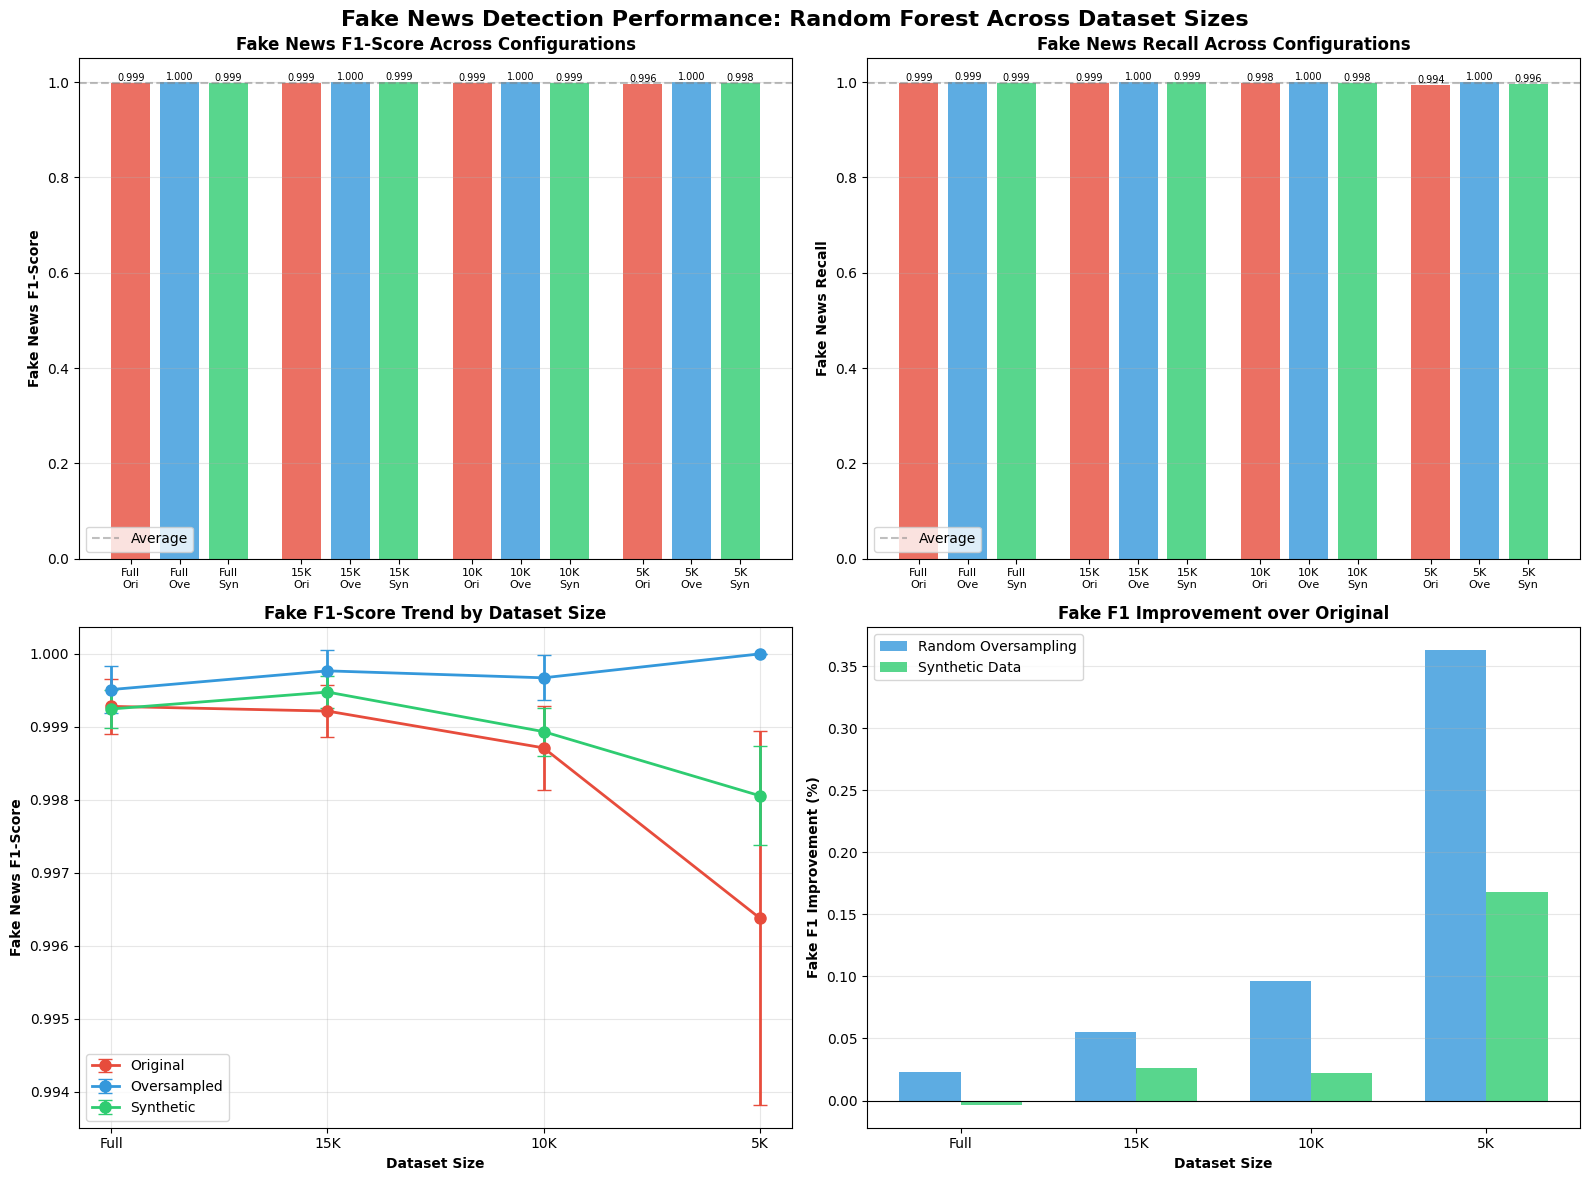

📊 Fake news detection visualizations created successfully!


In [33]:
# Visualize Fake News Detection Performance
if fake_metrics_df is not None and len(fake_metrics_df) > 0:
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Fake News Detection Performance: Random Forest Across Dataset Sizes', 
                 fontsize=16, fontweight='bold')
    
    size_order = ['Full', '15K', '10K', '5K']
    approach_order = ['Original', 'Oversampled', 'Synthetic']
    colors = {'Original': '#e74c3c', 'Oversampled': '#3498db', 'Synthetic': '#2ecc71'}
    
    # 1. Fake F1-Score comparison
    ax1 = axes[0, 0]
    
    x_positions = []
    fake_f1_scores = []
    labels = []
    bar_colors = []
    
    pos = 0
    for size in size_order:
        size_data = fake_metrics_df[fake_metrics_df['dataset_size'] == size]
        if len(size_data) > 0:
            for approach in approach_order:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    x_positions.append(pos)
                    fake_f1_scores.append(approach_data['fake_f1'].iloc[0])
                    labels.append(f"{size}\n{approach[:3]}")
                    bar_colors.append(colors[approach])
                    pos += 1
            pos += 0.5
    
    bars = ax1.bar(x_positions, fake_f1_scores, color=bar_colors, alpha=0.8, width=0.8)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(labels, rotation=0, fontsize=8)
    ax1.set_ylabel('Fake News F1-Score', fontweight='bold')
    ax1.set_title('Fake News F1-Score Across Configurations', fontweight='bold')
    ax1.axhline(y=fake_metrics_df['fake_f1'].mean(), color='gray', linestyle='--', alpha=0.5, label='Average')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, score in zip(bars, fake_f1_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom', fontsize=7)
    
    # 2. Fake Recall comparison
    ax2 = axes[0, 1]
    
    x_positions = []
    fake_recall_scores = []
    labels = []
    bar_colors = []
    
    pos = 0
    for size in size_order:
        size_data = fake_metrics_df[fake_metrics_df['dataset_size'] == size]
        if len(size_data) > 0:
            for approach in approach_order:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    x_positions.append(pos)
                    fake_recall_scores.append(approach_data['fake_recall'].iloc[0])
                    labels.append(f"{size}\n{approach[:3]}")
                    bar_colors.append(colors[approach])
                    pos += 1
            pos += 0.5
    
    bars = ax2.bar(x_positions, fake_recall_scores, color=bar_colors, alpha=0.8, width=0.8)
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(labels, rotation=0, fontsize=8)
    ax2.set_ylabel('Fake News Recall', fontweight='bold')
    ax2.set_title('Fake News Recall Across Configurations', fontweight='bold')
    ax2.axhline(y=fake_metrics_df['fake_recall'].mean(), color='gray', linestyle='--', alpha=0.5, label='Average')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, score in zip(bars, fake_recall_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom', fontsize=7)
    
    # 3. Trend by dataset size - Fake F1
    ax3 = axes[1, 0]
    
    for approach in approach_order:
        approach_data = fake_metrics_df[fake_metrics_df['approach'] == approach]
        
        sizes = []
        f1_means = []
        f1_stds = []
        
        for size in size_order:
            size_approach_data = approach_data[approach_data['dataset_size'] == size]
            if len(size_approach_data) > 0:
                sizes.append(size)
                f1_means.append(size_approach_data['fake_f1'].iloc[0])
                f1_stds.append(size_approach_data['std_fake_f1'].iloc[0])
        
        if sizes:
            x_pos = [size_order.index(s) for s in sizes]
            ax3.errorbar(x_pos, f1_means, yerr=f1_stds, marker='o', capsize=5, 
                        label=approach, linewidth=2, markersize=8, color=colors[approach])
    
    ax3.set_xlabel('Dataset Size', fontweight='bold')
    ax3.set_ylabel('Fake News F1-Score', fontweight='bold')
    ax3.set_title('Fake F1-Score Trend by Dataset Size', fontweight='bold')
    ax3.set_xticks(range(len(size_order)))
    ax3.set_xticklabels(size_order)
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. Fake F1 improvement over baseline
    ax4 = axes[1, 1]
    
    improvements = {'Oversampled': [], 'Synthetic': []}
    sizes_with_data = []
    
    for size in size_order:
        size_data = fake_metrics_df[fake_metrics_df['dataset_size'] == size]
        original_data = size_data[size_data['approach'] == 'Original']
        
        if len(original_data) > 0:
            baseline_f1 = original_data['fake_f1'].iloc[0]
            sizes_with_data.append(size)
            
            for approach in ['Oversampled', 'Synthetic']:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    approach_f1 = approach_data['fake_f1'].iloc[0]
                    improvement = ((approach_f1 - baseline_f1) / baseline_f1) * 100
                    improvements[approach].append(improvement)
                else:
                    improvements[approach].append(0)
    
    if sizes_with_data:
        x = np.arange(len(sizes_with_data))
        width = 0.35
        
        ax4.bar(x - width/2, improvements['Oversampled'], width, 
                label='Random Oversampling', color=colors['Oversampled'], alpha=0.8)
        ax4.bar(x + width/2, improvements['Synthetic'], width, 
                label='Synthetic Data', color=colors['Synthetic'], alpha=0.8)
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax4.set_xlabel('Dataset Size', fontweight='bold')
        ax4.set_ylabel('Fake F1 Improvement (%)', fontweight='bold')
        ax4.set_title('Fake F1 Improvement over Original', fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(sizes_with_data)
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Fake news detection visualizations created successfully!")
    
else:
    print("❌ Cannot create visualizations - no data available")

## 8. Held-Out Test Set Experiments

**Critical Issue Identified**: Cross-validation may be leaking oversampled data into test folds, artificially inflating performance metrics.

**Solution**: Create an independent test set BEFORE any data manipulation:
1. Split original data into **train (80%)** and **test (20%)** sets
2. Apply balancing techniques (oversampling/synthetic) ONLY to training data
3. Evaluate all models on the same held-out test set
4. This ensures test data is never seen during training, even indirectly

This provides a more realistic evaluation of model generalization.

In [6]:
# Create Held-Out Test Set from Original Data
from sklearn.model_selection import train_test_split

print("🔒 Creating held-out test set from original data...")
print("="*70)

if original_df is not None:
    # Separate real and fake from original data
    original_real_full = original_df[original_df['label'] == 1].copy()
    original_fake_full = original_df[original_df['label'] == 0].copy()
    
    print(f"\n📊 Original Data:")
    print(f"   Real articles: {len(original_real_full):,}")
    print(f"   Fake articles: {len(original_fake_full):,}")
    print(f"   Total: {len(original_df):,}")
    
    # Split each class separately to maintain class distribution (80/20 split)
    test_size = 0.2
    
    real_train, real_test = train_test_split(
        original_real_full[['text', 'label']], 
        test_size=test_size, 
        random_state=42
    )
    
    fake_train, fake_test = train_test_split(
        original_fake_full[['text', 'label']], 
        test_size=test_size, 
        random_state=42
    )
    
    # Combine train and test sets
    train_pool = pd.concat([real_train, fake_train], ignore_index=True)
    holdout_test = pd.concat([real_test, fake_test], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"\n✅ Train/Test Split Created:")
    print(f"   Training pool: {len(train_pool):,} articles")
    print(f"      Real: {len(real_train):,} | Fake: {len(fake_train):,}")
    print(f"   Test set (HELD-OUT): {len(holdout_test):,} articles")
    print(f"      Real: {len(real_test):,} | Fake: {len(fake_test):,}")
    
    print(f"\n🔒 Test set will be used for final evaluation only!")
    print(f"   All balancing techniques will be applied ONLY to training data")
    
else:
    print("❌ Original data not available")
    train_pool = None
    holdout_test = None

🔒 Creating held-out test set from original data...

📊 Original Data:
   Real articles: 11,272
   Fake articles: 9,050
   Total: 20,322

✅ Train/Test Split Created:
   Training pool: 16,257 articles
      Real: 9,017 | Fake: 7,240
   Test set (HELD-OUT): 4,065 articles
      Real: 2,255 | Fake: 1,810

🔒 Test set will be used for final evaluation only!
   All balancing techniques will be applied ONLY to training data


In [9]:
# Prepare Training Variants with Held-Out Test Set
print("🔄 Preparing training variants (test set excluded)...")
print("="*70)

holdout_train_variants = {}

if train_pool is not None and holdout_test is not None:
    # Get train data by class
    train_real = train_pool[train_pool['label'] == 1].copy()
    train_fake = train_pool[train_pool['label'] == 0].copy()
    
    print(f"\n📊 Training Pool (after holding out test):")
    print(f"   Real: {len(train_real):,} | Fake: {len(train_fake):,} | Total: {len(train_pool):,}")
    
    # Configuration 1: Full training data
    print(f"\n{'='*70}")
    print(f"📊 FULL TRAINING DATASET")
    
    # Variant 1A: Original Imbalanced
    full_train_original = train_pool[['text', 'label']].copy()
    holdout_train_variants['full_original'] = full_train_original
    print(f"   ✅ Original Imbalanced: {len(full_train_original):,} articles")
    print(f"      Real: {len(full_train_original[full_train_original['label']==1]):,} | Fake: {len(full_train_original[full_train_original['label']==0]):,}")
    
    # Variant 1B: Random Oversampled
    target_size = max(len(train_real), len(train_fake))
    
    if len(train_fake) < target_size:
        train_fake_oversampled = resample(train_fake[['text', 'label']], n_samples=target_size, random_state=42, replace=True)
    else:
        train_fake_oversampled = train_fake[['text', 'label']]
    
    if len(train_real) < target_size:
        train_real_oversampled = resample(train_real[['text', 'label']], n_samples=target_size, random_state=42, replace=True)
    else:
        train_real_oversampled = train_real[['text', 'label']]
    
    full_train_oversampled = pd.concat([train_real_oversampled, train_fake_oversampled], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    holdout_train_variants['full_oversampled'] = full_train_oversampled
    print(f"   ✅ Random Oversampled: {len(full_train_oversampled):,} articles")
    print(f"      Real: {len(full_train_oversampled[full_train_oversampled['label']==1]):,} | Fake: {len(full_train_oversampled[full_train_oversampled['label']==0]):,}")
    
    # Variant 1C: Synthetic Balanced
    if synthetic_df is not None and len(synthetic_df) >= 2222:
        synthetic_sample = synthetic_df[['text', 'label']].sample(n=2222, random_state=42)
        full_train_synthetic = pd.concat([
            train_fake[['text', 'label']],
            train_real[['text', 'label']],
            synthetic_sample
        ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
        holdout_train_variants['full_synthetic'] = full_train_synthetic
        print(f"   ✅ Synthetic Balanced: {len(full_train_synthetic):,} articles")
        print(f"      Real: {len(full_train_synthetic[full_train_synthetic['label']==1]):,} | Fake: {len(full_train_synthetic[full_train_synthetic['label']==0]):,}")
    
    # Configurations 2-4: Smaller training datasets (15k, 10k, 5k)
    configs = {
        '15k': {'fake': int(6389), 'real': int(8611)},  # 80% of original sizes
        '10k': {'fake': int(3889), 'real': int(6111)},
        '5k': {'fake': int(1389), 'real': int(3611)}
    }
    
    for config_name, sizes in configs.items():
        print(f"\n{'='*70}")
        print(f"📊 {config_name.upper()} TRAINING DATASET")
        
        if len(train_fake) >= sizes['fake'] and len(train_real) >= sizes['real']:
            # Sample from training pool only
            sampled_train_fake = train_fake.sample(n=sizes['fake'], random_state=42)
            sampled_train_real = train_real.sample(n=sizes['real'], random_state=42)
            
            # Variant A: Original Imbalanced
            variant_train_original = pd.concat([
                sampled_train_fake[['text', 'label']],
                sampled_train_real[['text', 'label']]
            ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
            holdout_train_variants[f'{config_name}_original'] = variant_train_original
            print(f"   ✅ Original Imbalanced: {len(variant_train_original):,} articles")
            print(f"      Real: {len(variant_train_original[variant_train_original['label']==1]):,} | Fake: {len(variant_train_original[variant_train_original['label']==0]):,}")
            
            # Variant B: Random Oversampled
            train_fake_oversampled = resample(
                sampled_train_fake[['text', 'label']],
                n_samples=sizes['real'],
                random_state=42,
                replace=True
            )
            variant_train_oversampled = pd.concat([
                train_fake_oversampled,
                sampled_train_real[['text', 'label']]
            ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
            holdout_train_variants[f'{config_name}_oversampled'] = variant_train_oversampled
            print(f"   ✅ Random Oversampled: {len(variant_train_oversampled):,} articles")
            print(f"      Real: {len(variant_train_oversampled[variant_train_oversampled['label']==1]):,} | Fake: {len(variant_train_oversampled[variant_train_oversampled['label']==0]):,}")
            
            # Variant C: Synthetic Balanced
            if synthetic_df is not None and len(synthetic_df) >= 2222:
                synthetic_sample = synthetic_df[['text', 'label']].sample(n=2222, random_state=42)
                variant_train_synthetic = pd.concat([
                    sampled_train_fake[['text', 'label']],
                    sampled_train_real[['text', 'label']],
                    synthetic_sample
                ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
                holdout_train_variants[f'{config_name}_synthetic'] = variant_train_synthetic
                print(f"   ✅ Synthetic Balanced: {len(variant_train_synthetic):,} articles")
                print(f"      Real: {len(variant_train_synthetic[variant_train_synthetic['label']==1]):,} | Fake: {len(variant_train_synthetic[variant_train_synthetic['label']==0]):,}")
        else:
            print(f"   ❌ Insufficient training data for {config_name}")
    
    print(f"\n{'='*70}")
    print(f"✅ All training variants prepared!")
    print(f"   Total variants: {len(holdout_train_variants)}")
    print(f"   Test set size: {len(holdout_test):,} (will be used for all variants)")
    
else:
    print("❌ Cannot prepare variants - training pool not available")
    holdout_train_variants = {}

🔄 Preparing training variants (test set excluded)...

📊 Training Pool (after holding out test):
   Real: 9,017 | Fake: 7,240 | Total: 16,257

📊 FULL TRAINING DATASET
   ✅ Original Imbalanced: 16,257 articles
      Real: 9,017 | Fake: 7,240
   ✅ Random Oversampled: 18,034 articles
      Real: 9,017 | Fake: 9,017
   ✅ Synthetic Balanced: 18,479 articles
      Real: 9,017 | Fake: 9,462

📊 15K TRAINING DATASET
   ✅ Original Imbalanced: 15,000 articles
      Real: 8,611 | Fake: 6,389
   ✅ Random Oversampled: 17,222 articles
      Real: 8,611 | Fake: 8,611
   ✅ Synthetic Balanced: 17,222 articles
      Real: 8,611 | Fake: 8,611

📊 10K TRAINING DATASET
   ✅ Original Imbalanced: 10,000 articles
      Real: 6,111 | Fake: 3,889
   ✅ Random Oversampled: 12,222 articles
      Real: 6,111 | Fake: 6,111
   ✅ Synthetic Balanced: 12,222 articles
      Real: 6,111 | Fake: 6,111

📊 5K TRAINING DATASET
   ✅ Original Imbalanced: 5,000 articles
      Real: 3,611 | Fake: 1,389
   ✅ Random Oversampled: 7,222

In [13]:
# Train and Evaluate on Held-Out Test Set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

print("🚀 Training models and evaluating on held-out test set...")
print("="*70)
print(f"🤖 Model: Random Forest (n_estimators=100)")
print(f"📊 Training variants: {len(holdout_train_variants)}")
print(f"🔒 Test set: {len(holdout_test):,} articles (same for all variants)")
print("="*70)

holdout_results = []

# Define experiment order
experiment_order_holdout = [
    ('full_original', 'FULL Dataset - Original Imbalanced'),
    ('full_oversampled', 'FULL Dataset - Random Oversampled'),
    ('full_synthetic', 'FULL Dataset - Synthetic Balanced'),
    ('15k_original', '15K Dataset - Original Imbalanced'),
    ('15k_oversampled', '15K Dataset - Random Oversampled'),
    ('15k_synthetic', '15K Dataset - Synthetic Balanced'),
    ('10k_original', '10K Dataset - Original Imbalanced'),
    ('10k_oversampled', '10K Dataset - Random Oversampled'),
    ('10k_synthetic', '10K Dataset - Synthetic Balanced'),
    ('5k_original', '5K Dataset - Original Imbalanced'),
    ('5k_oversampled', '5K Dataset - Random Oversampled'),
    ('5k_synthetic', '5K Dataset - Synthetic Balanced'),
]

if holdout_test is not None and len(holdout_train_variants) > 0:
    # Prepare test data (vectorize once, will reuse for all models)
    X_test = holdout_test['text']
    y_test = holdout_test['label']
    
    for i, (variant_key, variant_name) in enumerate(experiment_order_holdout, 1):
        if variant_key in holdout_train_variants:
            print(f"\n{'='*70}")
            print(f"🔬 EXPERIMENT {i}/12: {variant_name}")
            print(f"{'='*70}")
            
            train_data = holdout_train_variants[variant_key]
            X_train = train_data['text']
            y_train = train_data['label']
            
            print(f"   Training on: {len(train_data):,} articles")
            print(f"   Testing on:  {len(holdout_test):,} articles (held-out)")
            
            try:
                # Create and fit vectorizer on training data only
                vectorizer = TfidfVectorizer(**tfidf_params)
                X_train_tfidf = vectorizer.fit_transform(X_train)
                X_test_tfidf = vectorizer.transform(X_test)  # Transform test with training vocabulary
                
                print(f"   TF-IDF shape - Train: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")
                
                # Train Random Forest
                model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
                model.fit(X_train_tfidf, y_train)
                
                # Predict on held-out test set
                y_pred = model.predict(X_test_tfidf)
                y_proba = model.predict_proba(X_test_tfidf)[:, 1]
                
                # Calculate overall metrics
                accuracy = accuracy_score(y_test, y_pred)
                
                # Calculate class-specific metrics
                precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)
                
                # Class 0 = Fake, Class 1 = Real
                fake_precision = precision[0]
                fake_recall = recall[0]
                fake_f1 = f1[0]
                
                real_precision = precision[1]
                real_recall = recall[1]
                real_f1 = f1[1]
                
                # Overall weighted metrics
                overall_precision = (precision * support).sum() / support.sum()
                overall_recall = (recall * support).sum() / support.sum()
                overall_f1 = (f1 * support).sum() / support.sum()
                
                # ROC AUC
                roc_auc = roc_auc_score(y_test, y_proba)
                
                # Store results
                result = {
                    'variant': variant_name,
                    'variant_key': variant_key,
                    'train_size': len(train_data),
                    'test_size': len(holdout_test),
                    'accuracy': accuracy,
                    'overall_f1': overall_f1,
                    'overall_precision': overall_precision,
                    'overall_recall': overall_recall,
                    'fake_f1': fake_f1,
                    'fake_precision': fake_precision,
                    'fake_recall': fake_recall,
                    'real_f1': real_f1,
                    'real_precision': real_precision,
                    'real_recall': real_recall,
                    'roc_auc': roc_auc
                }
                
                holdout_results.append(result)
                
                print(f"   ✅ Accuracy: {accuracy:.4f}")
                print(f"   ✅ Overall F1: {overall_f1:.4f}")
                print(f"   ✅ Fake F1: {fake_f1:.4f} | Fake Recall: {fake_recall:.4f}")
                print(f"   ✅ Real F1: {real_f1:.4f} | Real Recall: {real_recall:.4f}")
                print(f"   ✅ ROC-AUC: {roc_auc:.4f}")
                
            except Exception as e:
                print(f"   ❌ Error: {str(e)}")
                continue
        else:
            print(f"\n⚠️  EXPERIMENT {i}/12: {variant_name} - SKIPPED (data not available)")
    
    print(f"\n{'='*70}")
    print(f"🎉 All held-out test experiments completed!")
    print(f"   Total results: {len(holdout_results)}")
    
    # Convert to DataFrame
    if holdout_results:
        holdout_results_df = pd.DataFrame(holdout_results)
        
        # Add dataset size and approach columns
        holdout_results_df['dataset_size'] = holdout_results_df['variant'].apply(
            lambda x: 'Full' if 'FULL' in x else '15K' if '15K' in x else '10K' if '10K' in x else '5K' if '5K' in x else 'Unknown'
        )
        holdout_results_df['approach'] = holdout_results_df['variant'].apply(
            lambda x: 'Original' if 'Original' in x else 'Oversampled' if 'Oversampled' in x else 'Synthetic' if 'Synthetic' in x else 'Unknown'
        )
        
        print(f"\n📊 SUMMARY (Held-Out Test Results):")
        print(holdout_results_df[['dataset_size', 'approach', 'overall_f1', 'fake_f1', 'accuracy']].to_string(index=False))
    else:
        print(f"❌ No results collected")
        holdout_results_df = None
else:
    print("❌ Cannot run experiments - test set or training variants not available")
    holdout_results_df = None

🚀 Training models and evaluating on held-out test set...
🤖 Model: Random Forest (n_estimators=100)
📊 Training variants: 12
🔒 Test set: 4,065 articles (same for all variants)

🔬 EXPERIMENT 1/12: FULL Dataset - Original Imbalanced
   Training on: 16,257 articles
   Testing on:  4,065 articles (held-out)
   TF-IDF shape - Train: (16257, 10000), Test: (4065, 10000)
   TF-IDF shape - Train: (16257, 10000), Test: (4065, 10000)
   ✅ Accuracy: 0.9993
   ✅ Overall F1: 0.9993
   ✅ Fake F1: 0.9992 | Fake Recall: 0.9983
   ✅ Real F1: 0.9993 | Real Recall: 1.0000
   ✅ ROC-AUC: 1.0000

🔬 EXPERIMENT 2/12: FULL Dataset - Random Oversampled
   Training on: 18,034 articles
   Testing on:  4,065 articles (held-out)
   ✅ Accuracy: 0.9993
   ✅ Overall F1: 0.9993
   ✅ Fake F1: 0.9992 | Fake Recall: 0.9983
   ✅ Real F1: 0.9993 | Real Recall: 1.0000
   ✅ ROC-AUC: 1.0000

🔬 EXPERIMENT 2/12: FULL Dataset - Random Oversampled
   Training on: 18,034 articles
   Testing on:  4,065 articles (held-out)
   TF-IDF sha

In [14]:
# Analyze Held-Out Test Results
if holdout_results_df is not None and len(holdout_results_df) > 0:
    print("📊 HELD-OUT TEST SET ANALYSIS")
    print("="*70)
    print("⚠️  These results show TRUE generalization performance (no data leakage)")
    print("="*70)
    
    # Performance by dataset size and approach
    print(f"\n📈 FAKE NEWS F1-SCORE (Held-Out Test):")
    print("-"*70)
    
    size_order = ['Full', '15K', '10K', '5K']
    approach_order = ['Original', 'Oversampled', 'Synthetic']
    
    for size in size_order:
        size_data = holdout_results_df[holdout_results_df['dataset_size'] == size]
        if len(size_data) > 0:
            print(f"\n{size} Dataset:")
            for approach in approach_order:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    fake_f1 = approach_data['fake_f1'].iloc[0]
                    fake_recall = approach_data['fake_recall'].iloc[0]
                    overall_f1 = approach_data['overall_f1'].iloc[0]
                    accuracy = approach_data['accuracy'].iloc[0]
                    print(f"   {approach:<15}: Fake F1={fake_f1:.4f} | Fake Recall={fake_recall:.4f} | Overall F1={overall_f1:.4f} | Acc={accuracy:.4f}")
    
    # Calculate improvements
    print(f"\n📊 IMPROVEMENT ANALYSIS (vs Original Baseline):")
    print("-"*70)
    
    for size in size_order:
        size_data = holdout_results_df[holdout_results_df['dataset_size'] == size]
        if len(size_data) > 0:
            original_data = size_data[size_data['approach'] == 'Original']
            oversampled_data = size_data[size_data['approach'] == 'Oversampled']
            synthetic_data = size_data[size_data['approach'] == 'Synthetic']
            
            if len(original_data) > 0:
                baseline_fake_f1 = original_data['fake_f1'].iloc[0]
                baseline_overall_f1 = original_data['overall_f1'].iloc[0]
                print(f"\n{size} Dataset (baseline - Fake F1: {baseline_fake_f1:.4f}, Overall F1: {baseline_overall_f1:.4f}):")
                
                if len(oversampled_data) > 0:
                    oversample_fake_f1 = oversampled_data['fake_f1'].iloc[0]
                    oversample_overall_f1 = oversampled_data['overall_f1'].iloc[0]
                    fake_improvement = ((oversample_fake_f1 - baseline_fake_f1) / baseline_fake_f1) * 100
                    overall_improvement = ((oversample_overall_f1 - baseline_overall_f1) / baseline_overall_f1) * 100
                    print(f"   Random Oversampling: Fake F1 {fake_improvement:+.2f}% | Overall F1 {overall_improvement:+.2f}%")
                
                if len(synthetic_data) > 0:
                    synthetic_fake_f1 = synthetic_data['fake_f1'].iloc[0]
                    synthetic_overall_f1 = synthetic_data['overall_f1'].iloc[0]
                    fake_improvement = ((synthetic_fake_f1 - baseline_fake_f1) / baseline_fake_f1) * 100
                    overall_improvement = ((synthetic_overall_f1 - baseline_overall_f1) / baseline_overall_f1) * 100
                    print(f"   Synthetic Data:      Fake F1 {fake_improvement:+.2f}% | Overall F1 {overall_improvement:+.2f}%")
                    
                    # Compare synthetic vs oversampling
                    if len(oversampled_data) > 0:
                        vs_oversample = ((synthetic_fake_f1 - oversample_fake_f1) / oversample_fake_f1) * 100
                        winner = "Synthetic" if synthetic_fake_f1 > oversample_fake_f1 else "Oversampling"
                        print(f"   → {winner} wins by {abs(vs_oversample):.2f}% (Fake F1)")
    
    # Overall best approach
    print(f"\n🏆 OVERALL PERFORMANCE (Held-Out Test):")
    print("-"*70)
    approach_avg = holdout_results_df.groupby('approach')[['fake_f1', 'overall_f1', 'accuracy']].mean()
    approach_avg = approach_avg.sort_values('fake_f1', ascending=False)
    
    for approach in approach_avg.index:
        stats = approach_avg.loc[approach]
        print(f"{approach:<15}: Mean Fake F1={stats['fake_f1']:.4f} | Overall F1={stats['overall_f1']:.4f} | Accuracy={stats['accuracy']:.4f}")
    
    # Best configuration
    best_fake_idx = holdout_results_df['fake_f1'].idxmax()
    best_config = holdout_results_df.loc[best_fake_idx]
    print(f"\n🥇 BEST CONFIGURATION (Fake News Detection):")
    print(f"   Dataset: {best_config['dataset_size']}")
    print(f"   Approach: {best_config['approach']}")
    print(f"   Fake F1: {best_config['fake_f1']:.4f}")
    print(f"   Fake Recall: {best_config['fake_recall']:.4f}")
    print(f"   Overall F1: {best_config['overall_f1']:.4f}")
    print(f"   Accuracy: {best_config['accuracy']:.4f}")
    
    # Compare with cross-validation results
    print(f"\n⚠️  COMPARISON WITH CROSS-VALIDATION RESULTS:")
    print(f"   If oversampling results are significantly worse here than in CV,")
    print(f"   it confirms data leakage was inflating CV performance.")
    
else:
    print("❌ No results to analyze")

📊 HELD-OUT TEST SET ANALYSIS
⚠️  These results show TRUE generalization performance (no data leakage)

📈 FAKE NEWS F1-SCORE (Held-Out Test):
----------------------------------------------------------------------

Full Dataset:
   Original       : Fake F1=0.9992 | Fake Recall=0.9983 | Overall F1=0.9993 | Acc=0.9993
   Oversampled    : Fake F1=0.9992 | Fake Recall=0.9983 | Overall F1=0.9993 | Acc=0.9993
   Synthetic      : Fake F1=0.9994 | Fake Recall=0.9989 | Overall F1=0.9995 | Acc=0.9995

15K Dataset:
   Original       : Fake F1=0.9992 | Fake Recall=0.9983 | Overall F1=0.9993 | Acc=0.9993
   Oversampled    : Fake F1=0.9986 | Fake Recall=0.9972 | Overall F1=0.9988 | Acc=0.9988
   Synthetic      : Fake F1=0.9992 | Fake Recall=0.9983 | Overall F1=0.9993 | Acc=0.9993

10K Dataset:
   Original       : Fake F1=0.9989 | Fake Recall=0.9978 | Overall F1=0.9990 | Acc=0.9990
   Oversampled    : Fake F1=0.9989 | Fake Recall=0.9978 | Overall F1=0.9990 | Acc=0.9990
   Synthetic      : Fake F1=0.998

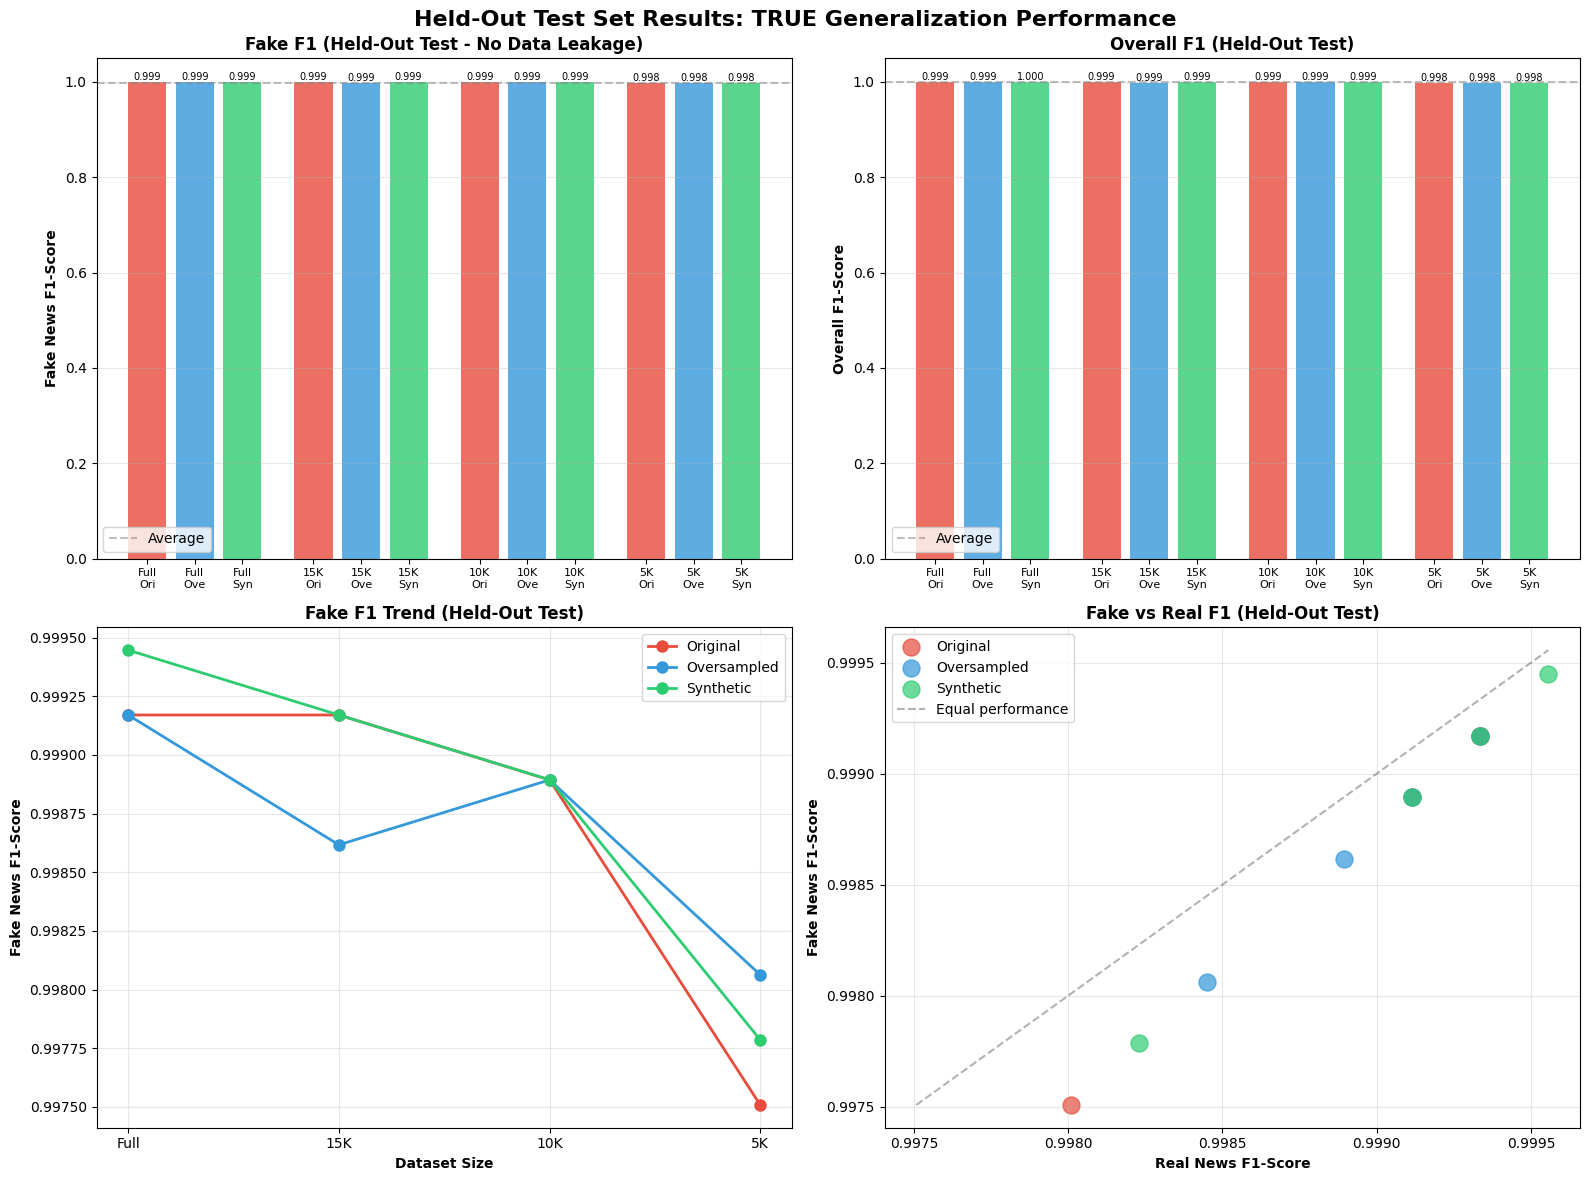

📊 Held-out test visualizations created successfully!


In [15]:
# Visualize Held-Out Test Results
if holdout_results_df is not None and len(holdout_results_df) > 0:
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Held-Out Test Set Results: TRUE Generalization Performance', 
                 fontsize=16, fontweight='bold')
    
    size_order = ['Full', '15K', '10K', '5K']
    approach_order = ['Original', 'Oversampled', 'Synthetic']
    colors = {'Original': '#e74c3c', 'Oversampled': '#3498db', 'Synthetic': '#2ecc71'}
    
    # 1. Fake F1-Score comparison
    ax1 = axes[0, 0]
    
    x_positions = []
    fake_f1_scores = []
    labels = []
    bar_colors = []
    
    pos = 0
    for size in size_order:
        size_data = holdout_results_df[holdout_results_df['dataset_size'] == size]
        if len(size_data) > 0:
            for approach in approach_order:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    x_positions.append(pos)
                    fake_f1_scores.append(approach_data['fake_f1'].iloc[0])
                    labels.append(f"{size}\n{approach[:3]}")
                    bar_colors.append(colors[approach])
                    pos += 1
            pos += 0.5
    
    bars = ax1.bar(x_positions, fake_f1_scores, color=bar_colors, alpha=0.8, width=0.8)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(labels, rotation=0, fontsize=8)
    ax1.set_ylabel('Fake News F1-Score', fontweight='bold')
    ax1.set_title('Fake F1 (Held-Out Test - No Data Leakage)', fontweight='bold')
    ax1.axhline(y=holdout_results_df['fake_f1'].mean(), color='gray', linestyle='--', alpha=0.5, label='Average')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, score in zip(bars, fake_f1_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom', fontsize=7)
    
    # 2. Overall F1-Score comparison
    ax2 = axes[0, 1]
    
    x_positions = []
    overall_f1_scores = []
    labels = []
    bar_colors = []
    
    pos = 0
    for size in size_order:
        size_data = holdout_results_df[holdout_results_df['dataset_size'] == size]
        if len(size_data) > 0:
            for approach in approach_order:
                approach_data = size_data[size_data['approach'] == approach]
                if len(approach_data) > 0:
                    x_positions.append(pos)
                    overall_f1_scores.append(approach_data['overall_f1'].iloc[0])
                    labels.append(f"{size}\n{approach[:3]}")
                    bar_colors.append(colors[approach])
                    pos += 1
            pos += 0.5
    
    bars = ax2.bar(x_positions, overall_f1_scores, color=bar_colors, alpha=0.8, width=0.8)
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(labels, rotation=0, fontsize=8)
    ax2.set_ylabel('Overall F1-Score', fontweight='bold')
    ax2.set_title('Overall F1 (Held-Out Test)', fontweight='bold')
    ax2.axhline(y=holdout_results_df['overall_f1'].mean(), color='gray', linestyle='--', alpha=0.5, label='Average')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, score in zip(bars, overall_f1_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom', fontsize=7)
    
    # 3. Fake F1 trend by dataset size
    ax3 = axes[1, 0]
    
    for approach in approach_order:
        approach_data = holdout_results_df[holdout_results_df['approach'] == approach]
        
        sizes = []
        f1_scores = []
        
        for size in size_order:
            size_approach_data = approach_data[approach_data['dataset_size'] == size]
            if len(size_approach_data) > 0:
                sizes.append(size)
                f1_scores.append(size_approach_data['fake_f1'].iloc[0])
        
        if sizes:
            x_pos = [size_order.index(s) for s in sizes]
            ax3.plot(x_pos, f1_scores, marker='o', label=approach, 
                    linewidth=2, markersize=8, color=colors[approach])
    
    ax3.set_xlabel('Dataset Size', fontweight='bold')
    ax3.set_ylabel('Fake News F1-Score', fontweight='bold')
    ax3.set_title('Fake F1 Trend (Held-Out Test)', fontweight='bold')
    ax3.set_xticks(range(len(size_order)))
    ax3.set_xticklabels(size_order)
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. Fake vs Real F1 scatter
    ax4 = axes[1, 1]
    
    for approach in approach_order:
        approach_data = holdout_results_df[holdout_results_df['approach'] == approach]
        ax4.scatter(approach_data['real_f1'], approach_data['fake_f1'], 
                   s=150, alpha=0.7, label=approach, color=colors[approach])
    
    # Add diagonal reference line
    min_val = min(holdout_results_df[['real_f1', 'fake_f1']].min())
    max_val = max(holdout_results_df[['real_f1', 'fake_f1']].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='Equal performance')
    
    ax4.set_xlabel('Real News F1-Score', fontweight='bold')
    ax4.set_ylabel('Fake News F1-Score', fontweight='bold')
    ax4.set_title('Fake vs Real F1 (Held-Out Test)', fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Held-out test visualizations created successfully!")
    
else:
    print("❌ Cannot create visualizations - no data available")